<a href="https://colab.research.google.com/github/mintyougurt/RUL-prediction-of-offshore-wind-turbine/blob/main/Part_2_GRU%2BBNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preprocessing**

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import datetime
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib as plt
import seaborn as sns
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ast
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy import stats
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [2]:
#define min-max function, note it is not standardization.
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=0)

#define function for getting the total number of neural network.
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [3]:
#define trend function
def compare_decreasing_trend(dataframe):
    decrease_percentages = []
    for column in dataframe.columns:
        line = dataframe[column].tolist()
        decrease_percentage = line[-1] - line[0]
        decrease_percentages.append(decrease_percentage)
    return decrease_percentages

In [4]:
dfr=pd.read_csv(r"/content/resLGBMT.csv",index_col=0)

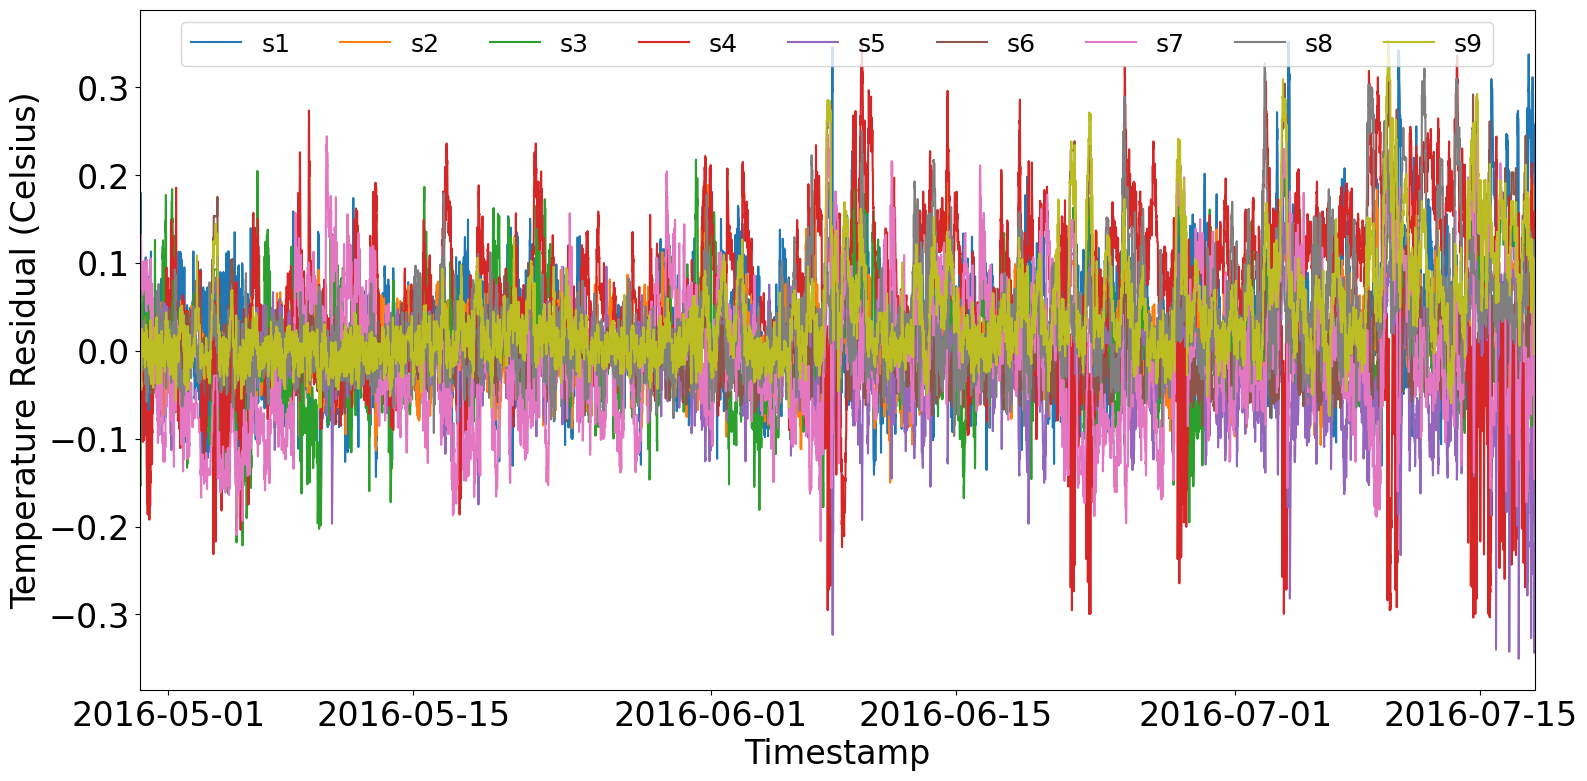

In [5]:
csfont = {'fontname':'Charis SIL'}
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 24})
dfr.index = pd.to_datetime(dfr.index, utc=True)

figsize=(16,9)
dfr.plot(figsize=(18,10))
plt.margins(x=0)
plt.legend(loc="upper center", ncol=len(dfr.columns), fontsize = 18)
plt.xticks(rotation='horizontal', ha='center')
plt.xlabel("Timestamp")
plt.ylabel("Temperature Residual (Celsius)")
plt.savefig('/content/dfro.pdf',bbox_inches='tight')

In [6]:
len(dfr)

11454

In [7]:
#finding the best winddow length
multiple = 6 * 24
window_lengths = [multiple * n for n in range(1, 60)]  # Adjust the range according to your needs

columns = dfr.columns
results = []

for window_length in window_lengths:
    rolling_windows = []
    decrease_rates = []
    dfrr = pd.DataFrame()

    for column in columns:
        dfrr[column] = dfr[column].pow(2).rolling(window_length).apply(lambda x: np.sqrt(x.mean()))
    dfrr = mean_norm(dfrr)
    dfrr = dfrr.dropna()
    current_decrease_rate = compare_decreasing_trend(dfrr)

    rolling_windows.append(window_length)
    decrease_rates.append(mean(current_decrease_rate))

    # Append the rolling windows and decrease rates for the current window length
    results.append((rolling_windows, decrease_rates, len(dfrr)))

In [8]:
# Extract the rolling windows, decrease rates, and data lengths from the results
rolling_windows = [res[0][0] for res in results]
decrease_rates = [res[1][0] for res in results]
data_lengths = [res[2] for res in results]

# Create a dictionary with the data
data = {
    'Rolling Windows': rolling_windows,
    'Decrease Rates': decrease_rates,
    'Data Length': data_lengths
}

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(data)
df_results.to_csv('results.csv', index=False)

In [9]:
df_results=pd.read_csv("results.csv")
df_results

,Rolling Windows,Decrease Rates,Data Length
0,144,0.438572,11311
1,288,0.543265,11167
2,432,0.592858,11023
3,576,0.684353,10879
4,720,0.635954,10735
5,864,0.577755,10591
6,1008,0.584682,10447
7,1152,0.621945,10303
8,1296,0.706796,10159
9,1440,0.732670,10015


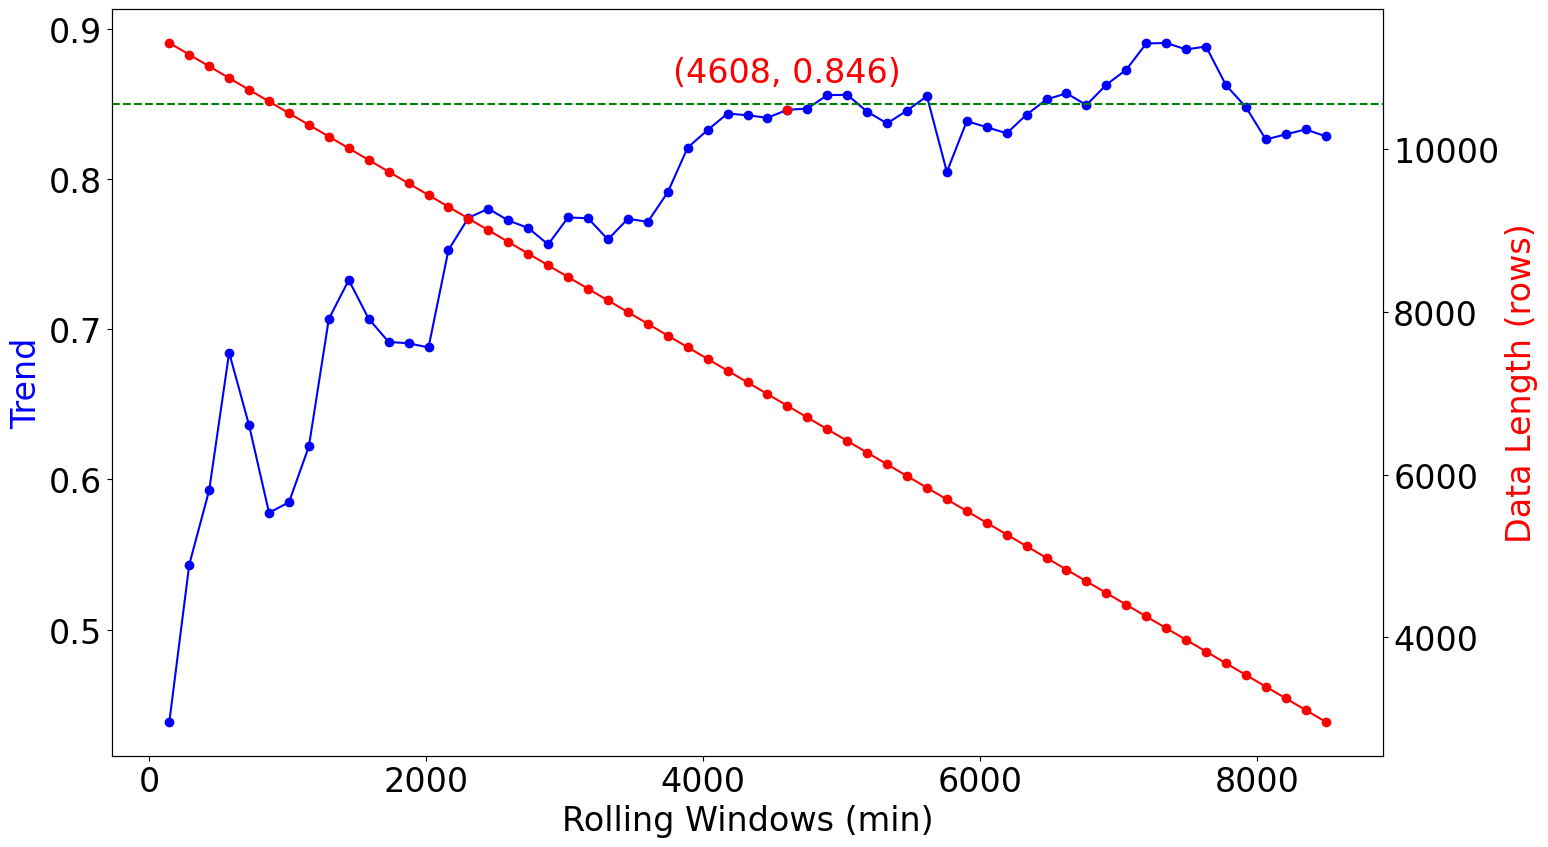

In [10]:
# Normalize the data length
normalized_data_length = df_results['Data Length'] / df_results['Data Length'].max()

# Calculate the sum of data length and decrease rate
sum_data_decrease = df_results['Data Length'] + df_results['Decrease Rates']
from scipy.signal import argrelextrema

# Find the indices of the first three points that approach or are less than 0.94 on the decrease rate curve
target_value = 0.95
# Calculate the absolute difference between the decrease rates and the threshold
difference = np.abs(df_results['Decrease Rates'] - 0.85)

# Find the indices of the first three points that approach the threshold value
approaching_indices = np.argsort(difference)[:5]

nearest_index=min(approaching_indices)

# Get the corresponding rolling window and decrease rate values
nearest_rolling_window = df_results['Rolling Windows'].iloc[nearest_index]
nearest_decrease_rate = df_results['Decrease Rates'].iloc[nearest_index]

# Calculate the derivative of the decrease rate
decrease_rate_derivative = np.gradient(df_results['Decrease Rates'])

fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(df_results['Rolling Windows'], df_results['Decrease Rates'], marker='o', linestyle='-', color='b')

ax1.set_xlabel('Rolling Windows (min)')
ax1.set_ylabel('Trend', color='b')

# Adding a horizontal line at y=0.95
ax1.axhline(y=0.85, color='g', linestyle='--',label='Threshold:0.85')


# Plotting the data lengths
ax2 = ax1.twinx()
ax2.plot(df_results['Rolling Windows'], df_results['Data Length'], marker='o', linestyle='-', color='r')
ax2.set_ylabel('Data Length (rows)', color='r')


# Adding a marker at the nearest point to 0.9
ax1.plot(nearest_rolling_window, df_results['Decrease Rates'].iloc[nearest_index], marker='o', color='r')

ax1.annotate(f'({nearest_rolling_window}, {round(nearest_decrease_rate, 3)})', xy=(nearest_rolling_window, df_results['Decrease Rates'].iloc[nearest_index]),
             xytext=(0, 20), textcoords='offset points', color='r',ha='center')

# Adjusting the layout
fig.tight_layout()
plt.savefig('/content/selectwin.pdf',bbox_inches='tight')
# Display the plot
plt.show()

In [11]:
rolling_window = 4608 #31days
columns = dfr.columns
dfrr = pd.DataFrame()
for column in columns:
    dfrr[column] = dfr[column].pow(2).rolling(rolling_window).apply(lambda x: np.sqrt(x.mean())) #RMS = sqrt((sum(x^2) / N))

dfrr=mean_norm(dfrr)
dfrr=dfrr.dropna()
print(dfrr)
decrease_rates = compare_decreasing_trend(dfrr)
print(decrease_rates)
print(mean(decrease_rates))

                                 s1        s2        s3        s4        s5  \
Timestamp                                                                     
2016-05-31 13:00:00+00:00  0.000000  0.000000  0.620187  0.000000  0.000000   
2016-05-31 13:10:00+00:00  0.001288  0.002793  0.620125  0.000584  0.000248   
2016-05-31 13:20:00+00:00  0.002269  0.006363  0.619140  0.001019  0.000612   
2016-05-31 13:30:00+00:00  0.003531  0.011736  0.618321  0.001499  0.001288   
2016-05-31 13:40:00+00:00  0.004452  0.015035  0.617102  0.002224  0.001501   
...                             ...       ...       ...       ...       ...   
2016-07-18 01:40:00+00:00  0.996055  0.996136  0.991269  0.982878  0.988452   
2016-07-18 01:50:00+00:00  0.997418  0.996360  0.991470  0.983092  0.990112   
2016-07-18 02:00:00+00:00  0.997826  0.996500  0.996347  0.983415  0.995260   
2016-07-18 02:10:00+00:00  0.998466  0.996900  0.998853  0.983725  0.997908   
2016-07-18 02:20:00+00:00  1.000000  1.000000  0.997

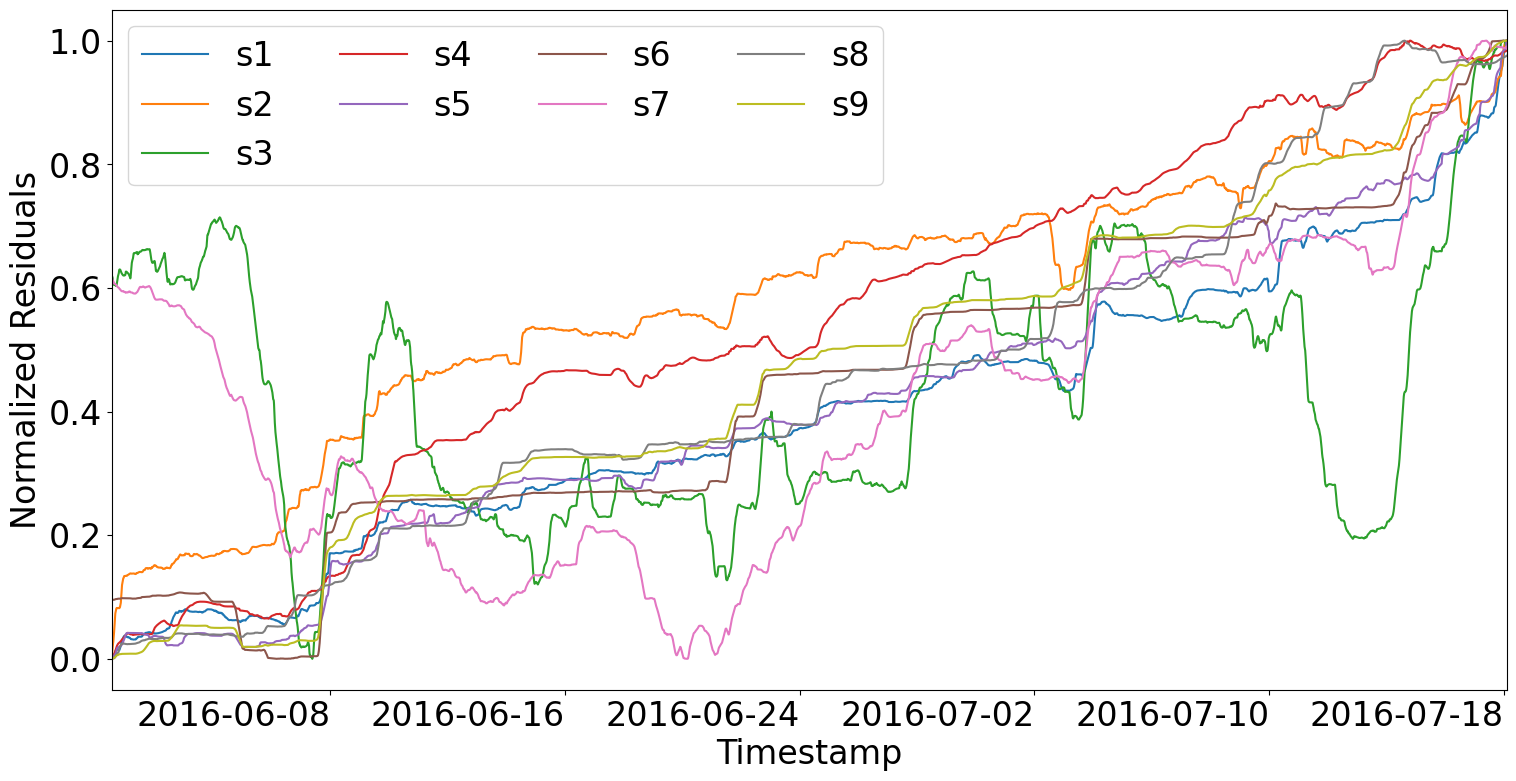

In [12]:
csfont = {'fontname':'Charis SIL'}

matplotlib.rcParams.update({'font.size': 24})
dfrr.index = pd.to_datetime(dfrr.index, utc=True)

ax=dfrr.plot(figsize=(18,10))
plt.margins(x=0)

plt.legend(loc="upper left", ncol=4, fontsize = 24)

plt.xticks(rotation='horizontal', ha='right')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.xlabel("Timestamp")
plt.ylabel("Normalized Residuals")
plt.savefig('/content/dfrr.pdf',bbox_inches='tight')

In [13]:
#PCA
from sklearn.decomposition import PCA
# Assuming your DataFrame is named 'dfr'

# Create a PCA instance with the same number of components as columns
n_components = dfrr.shape[1]  # Number of columns in 'dfr'
pca = PCA(n_components=n_components)

# Fit the PCA model to your data
pca.fit(dfrr)

# Transform the data using the fitted PCA model
transformed_data = pca.transform(dfrr)

# Create a new DataFrame for the transformed data
pca_df = pd.DataFrame(data=transformed_data, columns=["PC"+str(i+1) for i in range(n_components)])
pca_df.index=dfrr.index
# Print the explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_
for i, explained_var in enumerate(explained_variance_ratio):
    print(f"Explained Variance Ratio of Component {i+1}: {explained_var}")

# Print the transformed data DataFrame
print("Transformed Data:")
pca_df

Explained Variance Ratio of Component 1: 0.8622139809858081
Explained Variance Ratio of Component 2: 0.1131255676962801
Explained Variance Ratio of Component 3: 0.01724773223320695
Explained Variance Ratio of Component 4: 0.003421560191498955
Explained Variance Ratio of Component 5: 0.002002128750292203
Explained Variance Ratio of Component 6: 0.0009223461948192123
Explained Variance Ratio of Component 7: 0.000807104509897647
Explained Variance Ratio of Component 8: 0.00020752060296724972
Explained Variance Ratio of Component 9: 5.20588352296816e-05
Transformed Data:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Timestamp,,,,,,,,,
2016-05-31 13:00:00+00:00,-1.084235,0.604313,0.169569,0.003424,-0.022861,0.094050,0.016742,0.035603,-0.002958
2016-05-31 13:10:00+00:00,-1.082949,0.602448,0.167848,0.003618,-0.022347,0.092193,0.016588,0.035140,-0.003450
2016-05-31 13:20:00+00:00,-1.081563,0.600162,0.166847,0.004528,-0.022073,0.089805,0.016490,0.034100,-0.003884
2016-05-31 13:30:00+00:00,-1.079459,0.597436,0.165158,0.005796,-0.021677,0.086158,0.016362,0.032294,-0.004235
2016-05-31 13:40:00+00:00,-1.078117,0.594984,0.164349,0.006596,-0.021659,0.083923,0.016150,0.031528,-0.004587
...,...,...,...,...,...,...,...,...,...
2016-07-18 01:40:00+00:00,1.519214,0.438074,-0.141796,-0.007821,0.160856,-0.073960,0.087454,0.007183,-0.010054
2016-07-18 01:50:00+00:00,1.520763,0.438777,-0.141266,-0.007868,0.161260,-0.074673,0.089049,0.007424,-0.009957
2016-07-18 02:00:00+00:00,1.523604,0.442086,-0.144132,-0.009910,0.161720,-0.074246,0.092879,0.005617,-0.008851


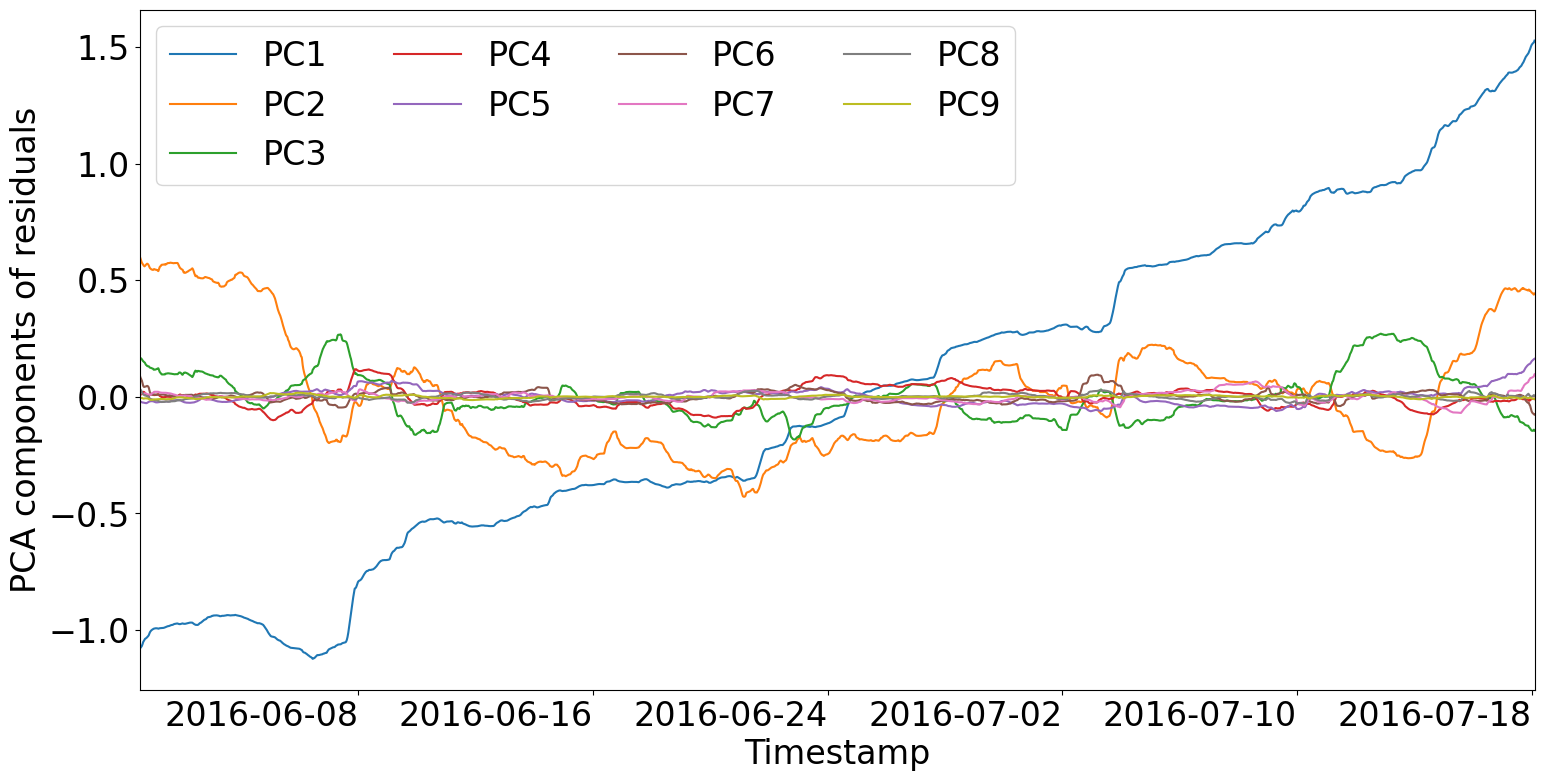

In [14]:
dfr=pca_df

csfont = {'fontname':'Charis SIL'}

matplotlib.rcParams.update({'font.size': 24})
dfr.index = pd.to_datetime(dfr.index, utc=True)

ax=dfr.plot(figsize=(18,10))
plt.margins(x=0)

plt.legend(loc="upper left", ncol=4, fontsize = 24)

plt.xticks(rotation='horizontal', ha='right')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.xlabel("Timestamp")
plt.ylabel("PCA components of residuals")
plt.savefig('/content/dfrr_pca.pdf',bbox_inches='tight')

In [15]:
dfr=pca_df

6847
[[1.00000000e+00]
 [9.99853972e-01]
 [9.99707944e-01]
 ...
 [2.92056075e-04]
 [1.46028037e-04]
 [0.00000000e+00]]


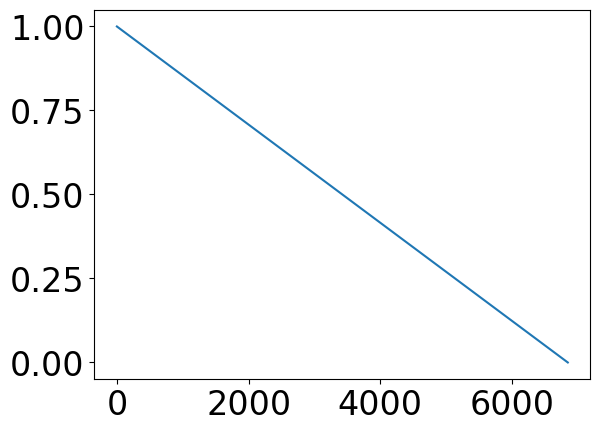

In [16]:
target=((datetime.datetime(2016, 7, 18,2,20,0)-pd.to_datetime(dfr.index.values)).total_seconds() / (3600)).values #hours

target = (target-min(target)) /(max(target)-min(target))

target=np.reshape(target,(len(dfr),1))

print(len(target))
print(target)
plt.plot(target)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train, test = train_test_split(dfr, test_size=0.2,shuffle=False)
a_o, b_o = train_test_split(target, test_size=0.2,shuffle=False)
train_shape=train.shape[0]
test_shape=test.shape[0]
a=train.to_numpy()
a=np.reshape(a,(len(a),1,len(dfr.columns)))
b=test.to_numpy()
b=np.reshape(b,(len(b),1,len(dfr.columns)))
input_seq = torch.from_numpy(a)
target_seq = torch.Tensor(a_o)
input_seq2 = torch.from_numpy(b)
target_seq2 = torch.Tensor(b_o)
torch_dataset= TensorDataset(input_seq,target_seq)
torch_dataset2= TensorDataset(input_seq2,target_seq2)

In [18]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [19]:
from torch.optim.lr_scheduler import StepLR

In [20]:
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [21]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=False)
# Define the number of folds

In [22]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
#LGBM#define loss function
def loss(y_true, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mae = metrics.mean_absolute_error(y_true, y_pred)
    return rmse+mae

In [24]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

# **Elastic net and SVR**

In [25]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split


kf = KFold(n_splits=5)
loss_scores = []
loss_scores2 = []

elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.05)

for train_index, test_index in kf.split(a):
    # Split the data into training and test sets for this fold
    a_train, a_test = a[train_index], a[test_index]
    a_o_train, a_o_test = a_o[train_index], a_o[test_index]

    # Fit the model to the training data
    elastic_net.fit(np.squeeze(a_train), a_o_train)

    # Make predictions on the validation data
    y_pred = elastic_net.predict(np.squeeze(a_test))

    # Make predictions on the train data
    y_preda = elastic_net.predict(np.squeeze(a_train))

    # Calculate the custom loss for this fold
    fold_loss = np.sqrt(mean_squared_error(a_o_test, y_pred))+mean_absolute_error(a_o_test, y_pred)
    loss_scores.append(fold_loss)

    # Calculate the custom loss for this fold
    fold_loss2 = np.sqrt(mean_squared_error(a_o_train, y_preda))+mean_absolute_error(a_o_train, y_preda)
    loss_scores2.append(fold_loss2)

# Calculate the mean and standard deviation of the loss scores
mean_loss = np.mean(loss_scores)
std_loss = np.std(loss_scores)

print("Loss scores for validation:", loss_scores)
print("Mean loss:", mean_loss)
print("Standard Deviation of loss:", std_loss)

# Calculate the mean and standard deviation of the loss scores
mean_loss2 = np.mean(loss_scores2)
std_loss2 = np.std(loss_scores2)

print("Loss scores for train:", loss_scores2)
print("Mean loss:", mean_loss2)
print("Standard Deviation of loss:", std_loss2)

Loss scores for validation: [0.09565943724201517, 0.1438398200792652, 0.06275478576532449, 0.025541656684717758, 0.11391389670913962]
Mean loss: 0.08834191929609245
Standard Deviation of loss: 0.0409537873106265
Loss scores for train: [0.05368161794539637, 0.04913685204384648, 0.06727530389524888, 0.07447195637674132, 0.07285715937566778]
Mean loss: 0.06348457792738017
Standard Deviation of loss: 0.010245902927464651


0.08552655620482046


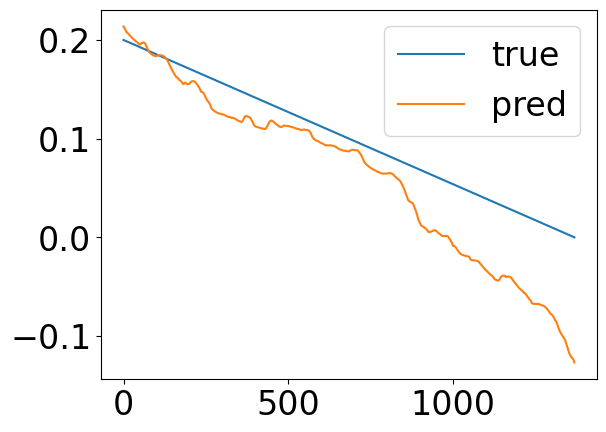

In [26]:
elastic_net = ElasticNet(alpha=0.001, l1_ratio=1)

# Fit the model to the training data
elastic_net.fit(np.squeeze(a), a_o)

# Make predictions on the test data
y_pred = elastic_net.predict(np.squeeze(b))

print(np.sqrt(mean_squared_error(b_o, y_pred))+mean_absolute_error(b_o, y_pred))
#y_preda = elastic_net.predict(np.squeeze(a_train))
plt.plot(b_o, label ="true")
plt.plot(y_pred, label = "pred")
plt.legend()

In [27]:
from sklearn.svm import SVR
svr = SVR(kernel='linear', C= 0.8, epsilon=0.1)

kf = KFold(n_splits=5)
loss_scores = []
loss_scores2 = []
for train_index, test_index in kf.split(a):
    # Split the data into training and test sets for this fold
    a_train, a_test = a[train_index], a[test_index]
    a_o_train, a_o_test = a_o[train_index], a_o[test_index]

    a_o_train = np.ravel(a_o_train)
    # Fit the model to the training data
    svr.fit(np.squeeze(a_train), a_o_train)

    # Make predictions on the validation data
    y_pred = svr.predict(np.squeeze(a_test))

    # Make predictions on the train data
    y_preda =svr.predict(np.squeeze(a_train))

    # Calculate the custom loss for this fold
    fold_loss = np.sqrt(mean_squared_error(a_o_test, y_pred))+mean_absolute_error(a_o_test, y_pred)
    loss_scores.append(fold_loss)

    # Calculate the custom loss for this fold
    fold_loss2 = np.sqrt(mean_squared_error(a_o_train, y_preda))+mean_absolute_error(a_o_train, y_preda)
    loss_scores2.append(fold_loss2)

# Calculate the mean and standard deviation of the loss scores
mean_loss = np.mean(loss_scores)
std_loss = np.std(loss_scores)

print("Loss scores for validation:", loss_scores)
print("Mean loss:", mean_loss)
print("Standard Deviation of loss:", std_loss)

# Calculate the mean and standard deviation of the loss scores
mean_loss2 = np.mean(loss_scores2)
std_loss2 = np.std(loss_scores2)

print("Loss scores for train:", loss_scores2)
print("Mean loss:", mean_loss2)
print("Standard Deviation of loss:", std_loss2)

Loss scores for validation: [0.1631146644137791, 0.1834502703374697, 0.0483575402030486, 0.06876224290394684, 0.25678763710220337]
Mean loss: 0.14409447099208952
Standard Deviation of loss: 0.0767475092670291
Loss scores for train: [0.11812713508861822, 0.10055119179220237, 0.12948105487736533, 0.12556578807632207, 0.11511888917140795]
Mean loss: 0.11776881180118319
Standard Deviation of loss: 0.010015651763179718


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.15111589975623985


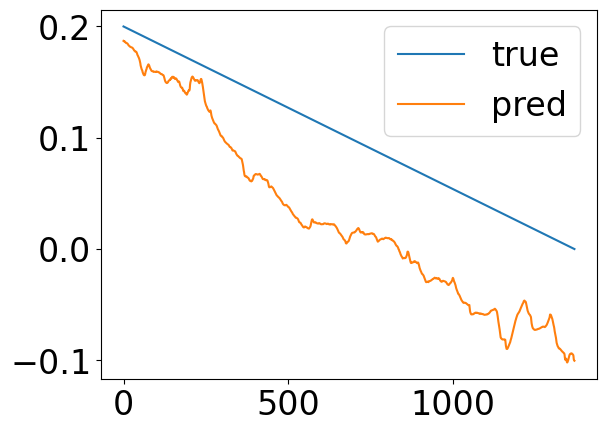

In [28]:
svr = SVR(kernel='linear', C= 10, epsilon=0.01)

# Fit the model to the training data
svr.fit(np.squeeze(a), a_o)

# Make predictions on the test data
y_pred = svr.predict(np.squeeze(b))

print(np.sqrt(mean_squared_error(b_o, y_pred))+mean_absolute_error(b_o, y_pred)) #per datapoint

#y_preda = elastic_net.predict(np.squeeze(a_train))
plt.plot(b_o, label ="true")
plt.plot(y_pred, label = "pred")
plt.legend()

# **GRU**

In [29]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRU, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers

        #self.LR = nn.InstanceNorm1d(1)

        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True, bias=True)

        # Fully connected layer,  linear transformation

        self.fc2 = nn.Linear(hidden_dim, output_size,bias=True)
        self.RELU = torch.nn.ReLU(inplace=True)

        self.to(device)

    def forward(self, x):

        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        #x = self.LR(x)
        out, hidden = self.gru(x, hidden)

        out = self.fc2(out)

        output=torch.squeeze(out)

        #output=  self.RELU(output)
        return output


    def init_hidden(self, batch_size):

        hidden = torch.zeros(self.n_layers, batch_size ,self.hidden_dim).cuda()
        return hidden

In [30]:
model1 = GRU(input_size=len(dfr.columns), output_size=1, hidden_dim=2, n_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.0001

# Define Loss, Optimizer
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=0.02)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

In [31]:
initialize_weights_xavier(model1)
model1.to(device)

GRU(
  (gru): GRU(9, 2, batch_first=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (RELU): ReLU(inplace=True)
)

In [32]:
get_parameter_number(model1)

{'Total': 81, 'Trainable': 81}

In [33]:
from sklearn.model_selection import KFold
time = datetime.datetime.now()
# Define the number of folds
k = 5
random_seed = 42
np.random.seed(random_seed)
set_seed(123)

torch.manual_seed(42)
# Initialize lists to store the losses and models
losses = []
val_losses = []
models = []
lossep = []
# Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=False)
fold = 0
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()

In [34]:
# Split the data and target into k folds
for train_index, val_index in kf.split(torch_dataset):
    # Create train loader for the current fold
    train_subset = torch.utils.data.Subset(torch_dataset, train_index)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create validation loader for the current fold
    val_subset = torch.utils.data.Subset(torch_dataset, val_index)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create a new instance of the model for each fold
    model = GRU(input_size=len(dfr.columns), output_size=1, hidden_dim=2, n_layers=1)
    initialize_weights_xavier(model)

    model.cuda()
    model.train()
    # Define hyperparameters
    n_epochs = 100
    lr=0.001
    loss_sum = []
    # Define Loss, Optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.02)
    scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

    # Train the model
    for epoch in range(1, n_epochs + 1):
        acc_loss = 0.
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = model(inputs.float())
            loss = criterion(output.unsqueeze(1), labels) + torch.sqrt(criterion2(output.unsqueeze(1), labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss

        loss_sum.append(acc_loss / len(train_loader))

        scheduler.step()
        if epoch % 20 == 0:
            print('Fold: {}/{} | Epoch: {}/{} | Loss: {:.4f}'.format(fold + 1, k, epoch, n_epochs, loss_sum[-1].item()))

    losses.append(loss_sum[-1].item()) #store average loss
    lossep.append(loss_sum) #store epoch loss

    # Validation
    model.eval()
    val_loss = 0.0
    total_samples2 = len(val_loader.dataset)
    with torch.no_grad():
        for inputs2, labels2 in val_loader:
            inputs2 = inputs2.cuda()
            labels2 = labels2.cuda()
            output2 = model(inputs2.float())
            loss2 = criterion(output2.unsqueeze(1), labels2) + torch.sqrt(criterion2(output2.unsqueeze(1), labels2))

            val_loss += loss2.item()

    val_loss_avg = val_loss / len(val_loader)

    print('Validation Loss: {:.4f}'.format(val_loss_avg))

    val_losses.append(val_loss_avg)
    models.append(model)
    fold += 1

print("Time={}".format(datetime.datetime.now()-time))

Fold: 1/5 | Epoch: 20/100 | Loss: 0.1664
Fold: 1/5 | Epoch: 40/100 | Loss: 0.0650
Fold: 1/5 | Epoch: 60/100 | Loss: 0.0526
Fold: 1/5 | Epoch: 80/100 | Loss: 0.0435
Fold: 1/5 | Epoch: 100/100 | Loss: 0.0392
Validation Loss: 0.0641
Fold: 2/5 | Epoch: 20/100 | Loss: 0.2647
Fold: 2/5 | Epoch: 40/100 | Loss: 0.0653
Fold: 2/5 | Epoch: 60/100 | Loss: 0.0323
Fold: 2/5 | Epoch: 80/100 | Loss: 0.0298
Fold: 2/5 | Epoch: 100/100 | Loss: 0.0291
Validation Loss: 0.1197
Fold: 3/5 | Epoch: 20/100 | Loss: 0.5779
Fold: 3/5 | Epoch: 40/100 | Loss: 0.4546
Fold: 3/5 | Epoch: 60/100 | Loss: 0.3257
Fold: 3/5 | Epoch: 80/100 | Loss: 0.1152
Fold: 3/5 | Epoch: 100/100 | Loss: 0.0515
Validation Loss: 0.0500
Fold: 4/5 | Epoch: 20/100 | Loss: 0.4084
Fold: 4/5 | Epoch: 40/100 | Loss: 0.1252
Fold: 4/5 | Epoch: 60/100 | Loss: 0.0614
Fold: 4/5 | Epoch: 80/100 | Loss: 0.0459
Fold: 4/5 | Epoch: 100/100 | Loss: 0.0407
Validation Loss: 0.0197
Fold: 5/5 | Epoch: 20/100 | Loss: 0.1415
Fold: 5/5 | Epoch: 40/100 | Loss: 0.058

In [35]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [36]:
def to_matrix(l, n):
   return [l[i:i+n] for i in range(0, len(l), n)]

In [37]:
#On testing set

ep=flatten(lossep)

ep = [tensor.item() for tensor in ep]

In [38]:
ep=pd.DataFrame(np.array(ep).reshape(5,100).T)

In [39]:
ep.columns=['model 1','model 2','model 3','model 4','model 5'] #,'model 6','model 7','model 8','model 9','model 10']

In [40]:
ep.to_csv("/content/ep.csv")

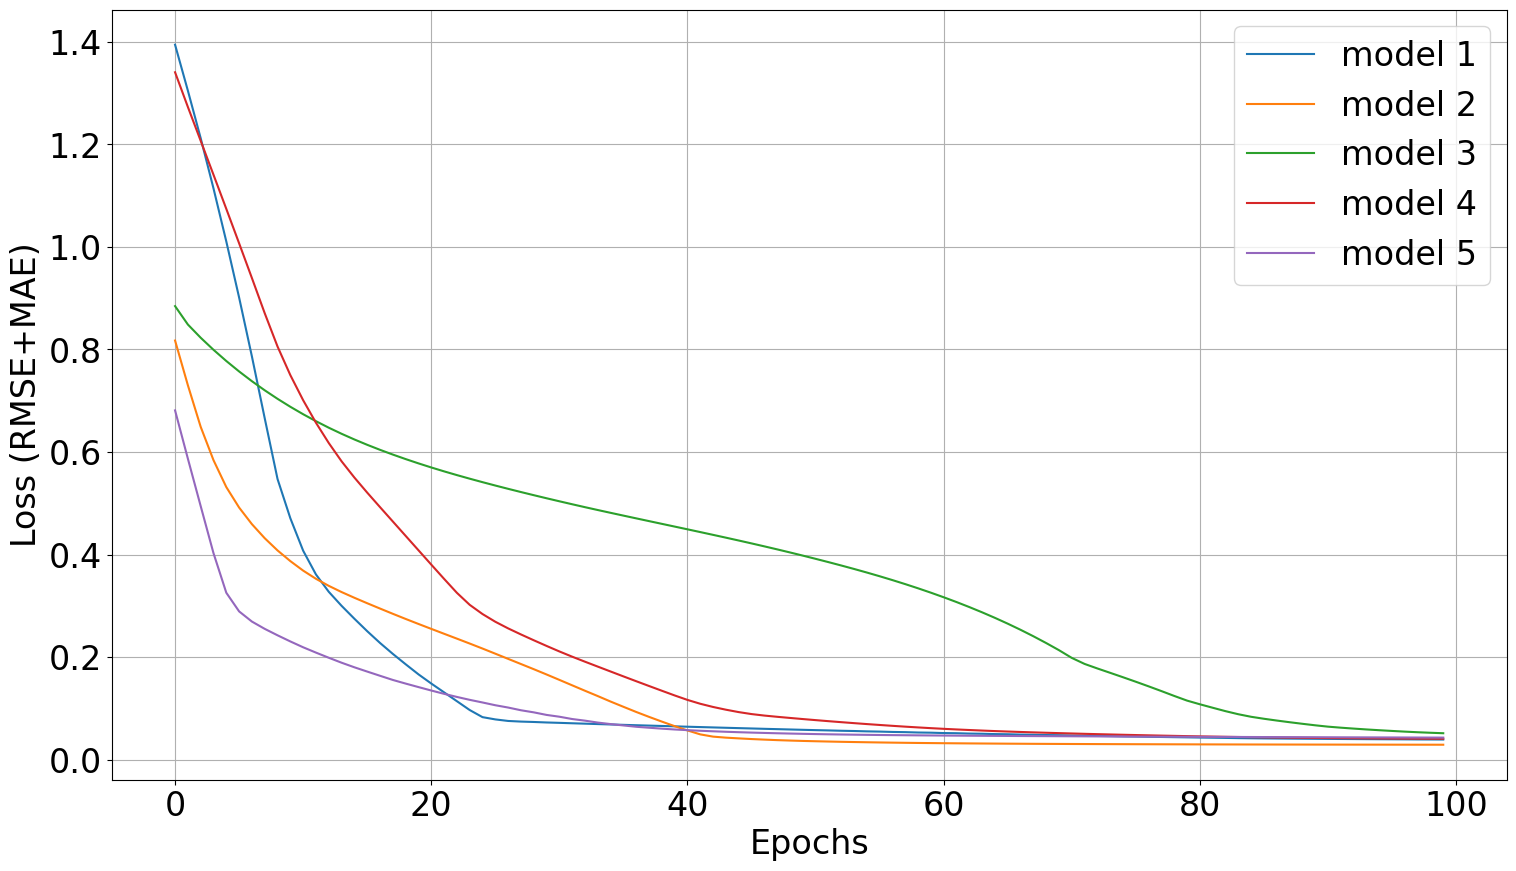

In [41]:
plt.style.use("default")
matplotlib.rcParams.update({'font.size':24})
plt.figure(figsize=(18,10))
x = range(n_epochs)
plt.plot(x, ep)
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE+MAE)')
plt.grid(True)
plt.legend(ep.columns,loc='upper right')
plt.xticks(rotation="horizontal", ha="center")
plt.savefig("/content/GRU.pdf",bbox_inches="tight")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
test_loader=DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
len(test_loader)

6

In [44]:
from sklearn.metrics import mean_absolute_error
import torch.utils.data as data
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
all_predictions = []
testing= []
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs3, labels3 in test_loader:
            inputs3= inputs3.cuda()
            labels3 = labels3.cuda()
            output3= model(inputs3.float())
            predictions.append(output3.cpu().numpy())
            actu_test += labels3
            loss = criterion(output3.unsqueeze(1), labels3) +torch.sqrt(criterion2(output3.unsqueeze(1), labels3))
            test_loss += loss.item()

    # Store the predictions for this model
    print(f'Testing Loss:{test_loss/len(test_loader)}')
    testing.append(test_loss/len(test_loader))
    all_predictions.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions = np.mean(all_predictions, axis=0)
real3 = [tensor.item() for tensor in actu_test]

error=mean_squared_error(ensemble_predictions, real3)**0.5  + mean_absolute_error(ensemble_predictions,real3)
print(error)
print(testing)

Testing Loss:0.21581386278072992
Testing Loss:0.03740426478907466
Testing Loss:0.10078512504696846
Testing Loss:0.10130863434945543
Testing Loss:0.09862375135223071
0.03251143003671294
[0.21581386278072992, 0.03740426478907466, 0.10078512504696846, 0.10130863434945543, 0.09862375135223071]


In [45]:
print('Average training Loss: {:.4f}'.format(mean(losses)))
print('Average Validation Loss: {:.4f}'.format(mean(val_losses)))
print('Average Testing Loss: {:.4f}'.format(mean(testing)))
print(losses)
print(val_losses)
print(testing)

Average training Loss: 0.0407
Average Validation Loss: 0.0591
Average Testing Loss: 0.1108
[0.03922777250409126, 0.029112137854099274, 0.051526766270399094, 0.040713682770729065, 0.04299726337194443]
[0.06412022672593594, 0.1196934849023819, 0.04997587986290455, 0.019699107110500335, 0.04207285270094872]
[0.21581386278072992, 0.03740426478907466, 0.10078512504696846, 0.10130863434945543, 0.09862375135223071]


In [46]:
# save prediction for test set
RUL=pd.DataFrame(all_predictions).T
RUL

,0,1,2,3,4
0,0.189582,0.207095,0.222394,0.203359,0.181381
1,0.189003,0.206593,0.222051,0.202915,0.180877
2,0.188367,0.206109,0.221761,0.202514,0.180389
3,0.187802,0.205629,0.221494,0.202133,0.179928
4,0.187046,0.205101,0.221149,0.201668,0.179379
...,...,...,...,...,...
1365,-0.155993,-0.049756,0.074583,0.128352,-0.078906
1366,-0.155798,-0.049999,0.074488,0.128402,-0.079123
1367,-0.155638,-0.050805,0.074125,0.128482,-0.079813
1368,-0.155849,-0.051327,0.073896,0.128537,-0.080289


In [47]:
#model on whole training set

train_loader=data.DataLoader(dataset=torch_dataset, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)

all_predictions2 = []
actu_test=[]
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss3 = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs4, labels4 in train_loader:
            inputs4 = inputs4.cuda()
            labels4 = labels4.cuda()
            output4 = model(inputs4.float())
            predictions.append(output4.cpu().numpy())
            actu_test += labels4
            loss = criterion(output4.unsqueeze(1), labels4) +torch.sqrt(criterion2(output4.unsqueeze(1), labels4))
            test_loss3 += loss.item()
    # Store the predictions for this model
    print(f'Training Loss:{test_loss3/(len(train_loader))}')

    all_predictions2.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions2 = np.mean(all_predictions2, axis=0)
real2 = [tensor.item() for tensor in actu_test]

error2=np.sqrt(mean_squared_error(ensemble_predictions2, real2))  + mean_absolute_error(ensemble_predictions2, real2)

print(error2)

Training Loss:0.04368808890946887
Training Loss:0.0455764356831258
Training Loss:0.05053564241494645
Training Loss:0.03644338474524292
Training Loss:0.04357138182967901
0.047067890416098976


<Axes: >

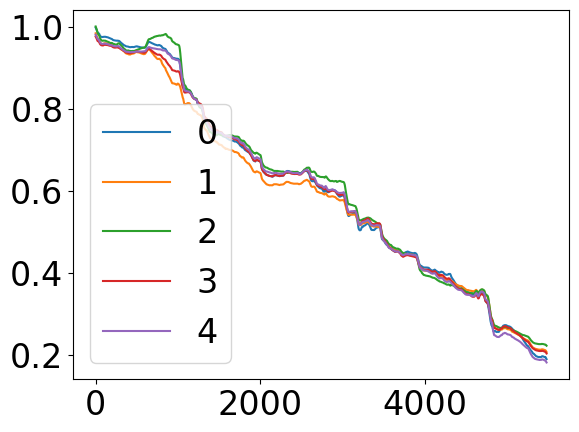

In [48]:
RULT=pd.DataFrame(all_predictions2).T
RULT.plot()

<Axes: >

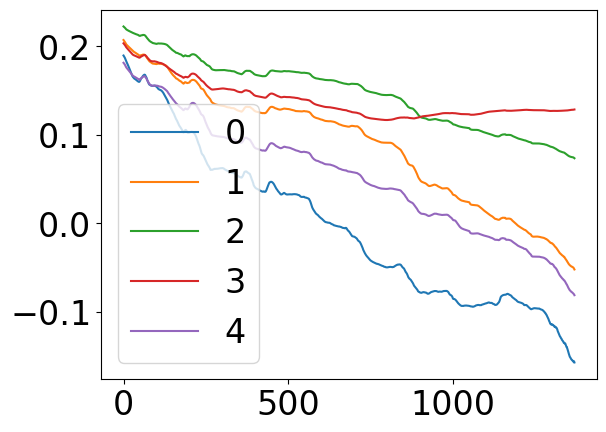

In [49]:
RUL.plot()

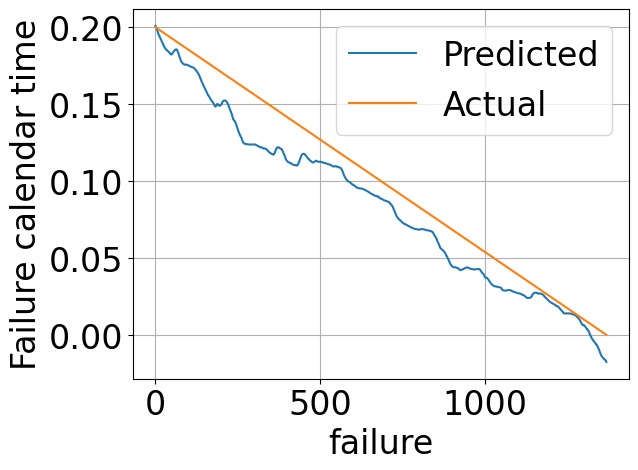

In [50]:
plt.figsize=(16,9)
plt.plot(ensemble_predictions, label='Predicted')
plt.plot(real3, label='Actual')
plt.xlabel('failure')
plt.ylabel('Failure calendar time')
plt.grid()  # 生成网格
plt.legend()
plt.show()

# **RNN**

In [54]:
class RNNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers

        # RNN Layer
        #self.LR =  nn.InstanceNorm1d(1)
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True,bias=True)

        # Fully connected layer,  linear transformation

        self.fc2 = nn.Linear(hidden_dim, output_size,bias=True)

        self.to(device)

    def forward(self, x):

        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        #x =self.LR(x)
        out, hidden = self.rnn(x, hidden)

        out = self.fc2(out)

        output=torch.squeeze(out)

        return output


    def init_hidden(self, batch_size):

        hidden = torch.zeros(self.n_layers, batch_size ,self.hidden_dim).cuda()
        return hidden

In [55]:
model2 = RNNN(input_size=len(dfr.columns), output_size=1, hidden_dim=5, n_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.0001

# Define Loss, Optimizer
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=0.02)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

In [56]:
initialize_weights_xavier(model2)
model2.to(device)

RNNN(
  (rnn): RNN(9, 5, batch_first=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [57]:
get_parameter_number(model2)

{'Total': 86, 'Trainable': 86}

In [70]:
from sklearn.model_selection import KFold
time = datetime.datetime.now()
# Define the number of folds
k = 5
set_seed(123)
torch.manual_seed(42)
# Initialize lists to store the losses and models
losses = []
val_losses = []
models = []
lossep = []
# Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=False)
fold = 0
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()

In [71]:
# Split the data and target into k folds
for train_index, val_index in kf.split(torch_dataset):
    # Create train loader for the current fold
    train_subset = torch.utils.data.Subset(torch_dataset, train_index)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create validation loader for the current fold
    val_subset = torch.utils.data.Subset(torch_dataset, val_index)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create a new instance of the model for each fold
    model = RNNN(input_size=len(dfr.columns), output_size=1, hidden_dim=5, n_layers=1) #edit
    initialize_weights_xavier(model)

    model.cuda()
    model.train()
    # Define hyperparameters
    n_epochs = 100
    lr=0.001
    loss_sum = []
    # Define Loss, Optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

    # Train the model
    for epoch in range(1, n_epochs + 1):
        acc_loss = 0.
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = model(inputs.float())
            loss = criterion(output.unsqueeze(1), labels) + torch.sqrt(criterion2(output.unsqueeze(1), labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss

        loss_sum.append(acc_loss / len(train_loader))

        scheduler.step()
        if epoch % 20 == 0:
            print('Fold: {}/{} | Epoch: {}/{} | Loss: {:.4f}'.format(fold + 1, k, epoch, n_epochs, loss_sum[-1].item()))

    losses.append(loss_sum[-1].item()) #store average loss
    lossep.append(loss_sum) #store epoch loss

    # Validation
    model.eval()
    val_loss = 0.0
    total_samples2 = len(val_loader.dataset)
    with torch.no_grad():
        for inputs2, labels2 in val_loader:
            inputs2 = inputs2.cuda()
            labels2 = labels2.cuda()
            output2 = model(inputs2.float())
            loss2 = criterion(output2.unsqueeze(1), labels2) + torch.sqrt(criterion2(output2.unsqueeze(1), labels2))

            val_loss += loss2.item()

    val_loss_avg = val_loss / len(val_loader)

    print('Validation Loss: {:.4f}'.format(val_loss_avg))

    val_losses.append(val_loss_avg)
    models.append(model)
    fold += 1

print("Time={}".format(datetime.datetime.now()-time))

Fold: 1/5 | Epoch: 20/100 | Loss: 0.1201
Fold: 1/5 | Epoch: 40/100 | Loss: 0.0685
Fold: 1/5 | Epoch: 60/100 | Loss: 0.0438
Fold: 1/5 | Epoch: 80/100 | Loss: 0.0386
Fold: 1/5 | Epoch: 100/100 | Loss: 0.0389
Validation Loss: 0.1408
Fold: 2/5 | Epoch: 20/100 | Loss: 0.0347
Fold: 2/5 | Epoch: 40/100 | Loss: 0.0333
Fold: 2/5 | Epoch: 60/100 | Loss: 0.0317
Fold: 2/5 | Epoch: 80/100 | Loss: 0.0335
Fold: 2/5 | Epoch: 100/100 | Loss: 0.0332
Validation Loss: 0.1303
Fold: 3/5 | Epoch: 20/100 | Loss: 0.0988
Fold: 3/5 | Epoch: 40/100 | Loss: 0.0460
Fold: 3/5 | Epoch: 60/100 | Loss: 0.0455
Fold: 3/5 | Epoch: 80/100 | Loss: 0.0460
Fold: 3/5 | Epoch: 100/100 | Loss: 0.0459
Validation Loss: 0.0797
Fold: 4/5 | Epoch: 20/100 | Loss: 0.1023
Fold: 4/5 | Epoch: 40/100 | Loss: 0.0547
Fold: 4/5 | Epoch: 60/100 | Loss: 0.0535
Fold: 4/5 | Epoch: 80/100 | Loss: 0.0531
Fold: 4/5 | Epoch: 100/100 | Loss: 0.0529
Validation Loss: 0.0287
Fold: 5/5 | Epoch: 20/100 | Loss: 0.1841
Fold: 5/5 | Epoch: 40/100 | Loss: 0.056

In [72]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [73]:
def to_matrix(l, n):
   return [l[i:i+n] for i in range(0, len(l), n)]

In [74]:
#On testing set

ep=flatten(lossep)

ep = [tensor.item() for tensor in ep]

In [75]:
ep=pd.DataFrame(np.array(ep).reshape(5,100).T)

In [64]:
ep.columns=['model 1','model 2','model 3','model 4','model 5'] #,'model 6','model 7','model 8','model 9','model 10']

In [ ]:
ep.to_csv("/content/ep.csv")

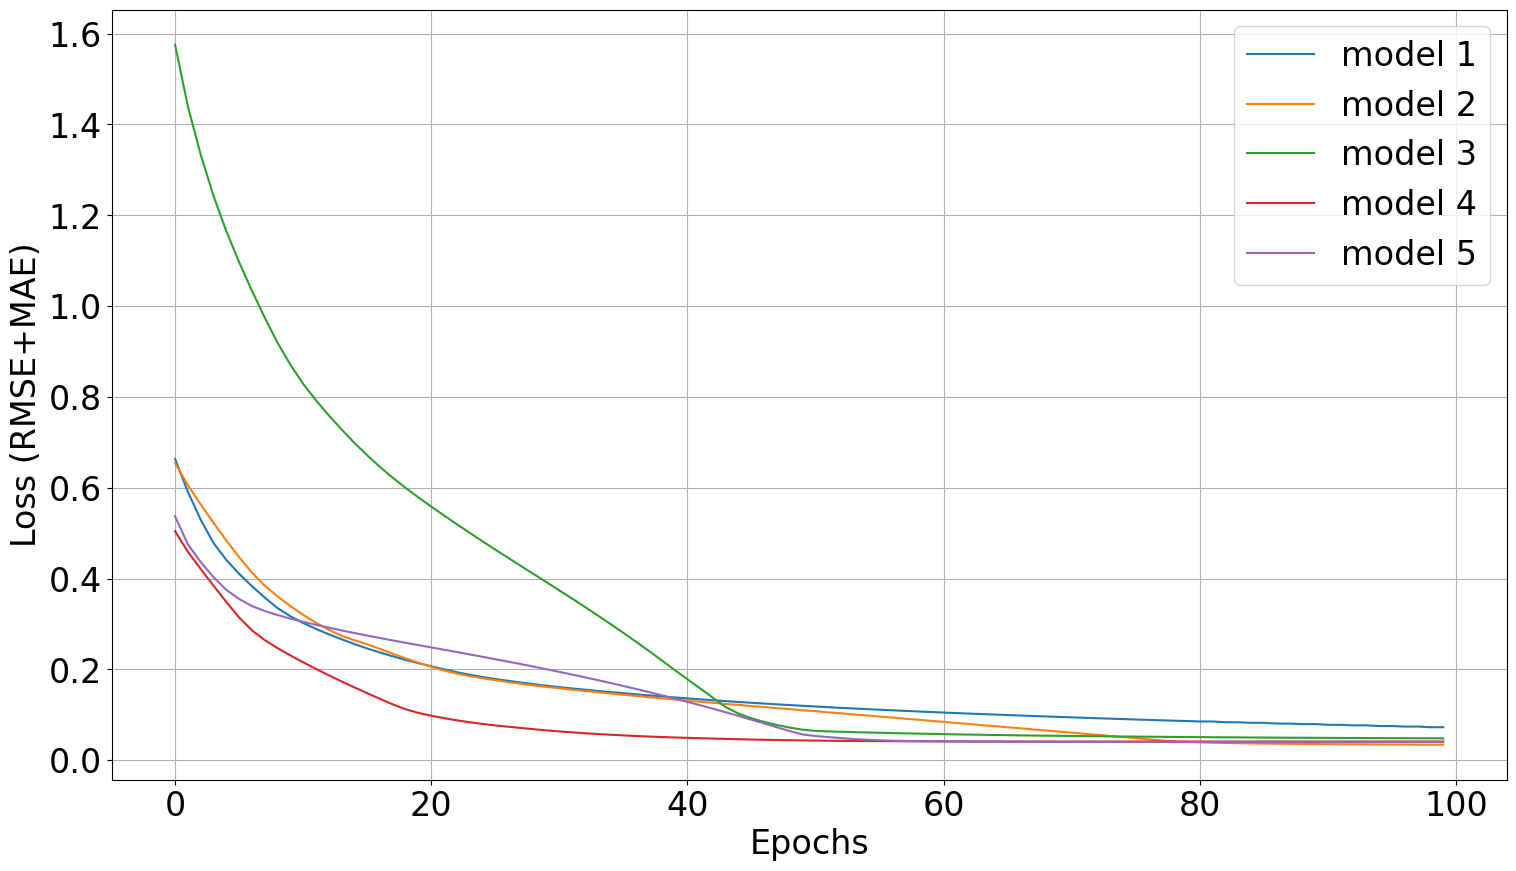

In [65]:
plt.style.use("default")
matplotlib.rcParams.update({'font.size':24})
plt.figure(figsize=(18,10))
x = range(n_epochs)
plt.plot(x, ep)
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE+MAE)')
plt.grid(True)
plt.legend(ep.columns,loc='upper right')
plt.xticks(rotation="horizontal", ha="center")
plt.savefig("/content/RNN.pdf",bbox_inches="tight")
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [67]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
len(test_loader)

6

In [76]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
all_predictions = []
testing= []
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs3, labels3 in test_loader:
            inputs3= inputs3.cuda()
            labels3 = labels3.cuda()
            output3= model(inputs3.float())
            predictions.append(output3.cpu().numpy())
            actu_test += labels3
            loss = criterion(output3.unsqueeze(1), labels3) +torch.sqrt(criterion2(output3.unsqueeze(1), labels3))
            test_loss += loss.item()

    # Store the predictions for this model
    print(f'Testing Loss:{test_loss/len(test_loader)}')
    testing.append(test_loss/len(test_loader))
    all_predictions.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions = np.mean(all_predictions, axis=0)
real3 = [tensor.item() for tensor in actu_test]

error=mean_squared_error(ensemble_predictions, real3)**0.5  + mean_absolute_error(ensemble_predictions,real3)
print(error)
print(testing)

Testing Loss:0.13286195633312067
Testing Loss:0.11852393423517545
Testing Loss:0.1507124031583468
Testing Loss:0.09994289465248585
Testing Loss:0.15727130075295767
0.12722971473585193
[0.13286195633312067, 0.11852393423517545, 0.1507124031583468, 0.09994289465248585, 0.15727130075295767]


In [77]:
print('Average training Loss: {:.4f}'.format(mean(losses)))
print('Average Validation Loss: {:.4f}'.format(mean(val_losses)))
print('Average Testing Loss: {:.4f}'.format(mean(testing)))
print(losses)
print(val_losses)
print(testing)

Average training Loss: 0.0444
Average Validation Loss: 0.0843
Average Testing Loss: 0.1319
[0.03885180130600929, 0.03319477662444115, 0.04586044326424599, 0.05285272374749184, 0.05117853730916977]
[0.1408161088824272, 0.1303223967552185, 0.07972743213176728, 0.028656578063964842, 0.041734615713357924]
[0.13286195633312067, 0.11852393423517545, 0.1507124031583468, 0.09994289465248585, 0.15727130075295767]


In [ ]:
# save prediction for test set
RUL=pd.DataFrame(all_predictions).T
RUL

,0,1,2,3,4
0,0.211186,0.231104,0.236021,0.224569,0.221687
1,0.211034,0.231003,0.235951,0.224482,0.221532
2,0.210867,0.230885,0.235874,0.224381,0.221371
3,0.210752,0.230807,0.235825,0.224314,0.221263
4,0.210565,0.230709,0.235759,0.224222,0.221109
...,...,...,...,...,...
1394,-0.129069,0.004090,0.061526,0.112343,-0.033432
1395,-0.129356,0.003834,0.061414,0.112363,-0.033717
1396,-0.129443,0.003439,0.061251,0.112401,-0.034042
1397,-0.129717,0.003118,0.061113,0.112428,-0.034349


In [ ]:
#model on whole training set

train_loader=data.DataLoader(dataset=torch_dataset, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)

all_predictions2 = []
actu_test=[]
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss3 = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs4, labels4 in train_loader:
            inputs4 = inputs4.cuda()
            labels4 = labels4.cuda()
            output4 = model(inputs4.float())
            predictions.append(output4.cpu().numpy())
            actu_test += labels4
            loss = criterion(output4.unsqueeze(1), labels4) +torch.sqrt(criterion2(output4.unsqueeze(1), labels4))
            test_loss3 += loss.item()
    # Store the predictions for this model
    print(f'Training Loss:{test_loss3/(len(train_loader))}')

    all_predictions2.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions2 = np.mean(all_predictions2, axis=0)
real2 = [tensor.item() for tensor in actu_test]

error2=np.sqrt(mean_squared_error(ensemble_predictions2, real2))  + mean_absolute_error(ensemble_predictions2, real2)

print(error2)

Training Loss:0.051371758034371814
Training Loss:0.04896288656670114
Training Loss:0.05428468014882958
Training Loss:0.04828165038286344
Training Loss:0.04383489932945889
0.04868884388517003


<Axes: >

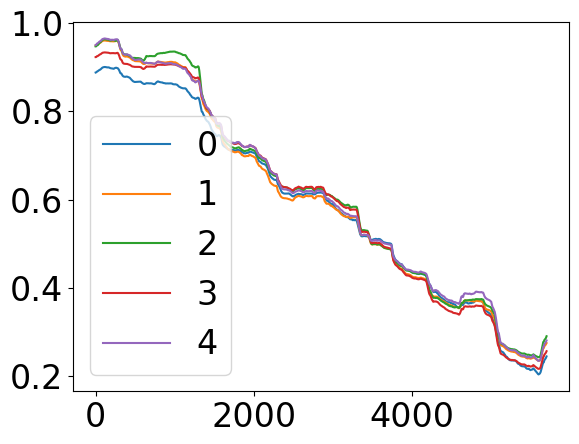

In [ ]:
RULT=pd.DataFrame(all_predictions2).T
RULT.plot()

In [ ]:
RUL.plot()

NameError: ignored

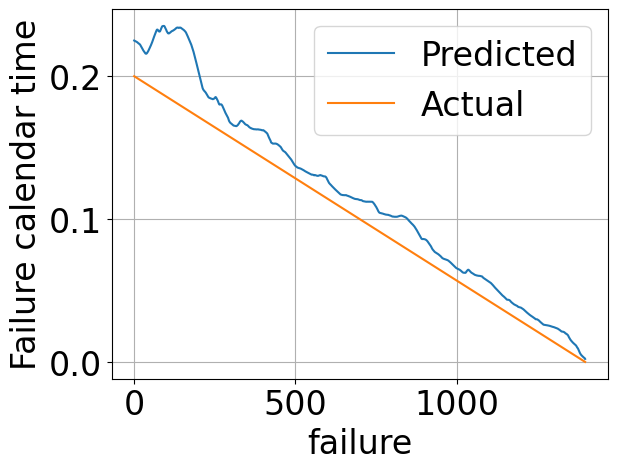

In [ ]:
plt.figsize=(16,9)
plt.plot(ensemble_predictions, label='Predicted')
plt.plot(real3, label='Actual')
plt.xlabel('failure')
plt.ylabel('Failure calendar time')
plt.grid()  # 生成网格
plt.legend()
plt.show()

# **LSTM**

In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers


        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # Fully connected layer,  linear transformation

        self.fc = nn.Linear(hidden_dim, output_size)

        self.to(device)


    def forward(self, x):

        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        #out = self.conv1(x)


        # Passing in the input and hidden state into the model and obtaining outputs

        out, hidden = self.rnn(x, (hidden,hidden))

        fc = self.fc(out)

        #36x1x94

        output=torch.squeeze(fc)

        return output


    def init_hidden(self, batch_size):

        hidden = torch.zeros(self.n_layers, batch_size ,self.hidden_dim).cuda()
        return hidden

In [79]:
model3 = LSTM(input_size=len(dfr.columns), output_size=1, hidden_dim=2, n_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.0001

# Define Loss, Optimizer
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=lr, weight_decay=0.02)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

In [80]:
initialize_weights_xavier(model3)
model3.to(device)

LSTM(
  (rnn): LSTM(9, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [81]:
get_parameter_number(model3)

{'Total': 107, 'Trainable': 107}

In [92]:
from sklearn.model_selection import KFold
time = datetime.datetime.now()
# Define the number of folds
k = 5
set_seed(123)
torch.manual_seed(42)
# Initialize lists to store the losses and models
losses = []
val_losses = []
models = []
lossep = []
# Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=False)
fold = 0
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()

In [93]:
# Split the data and target into k folds
for train_index, val_index in kf.split(torch_dataset):
    # Create train loader for the current fold
    train_subset = torch.utils.data.Subset(torch_dataset, train_index)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create validation loader for the current fold
    val_subset = torch.utils.data.Subset(torch_dataset, val_index)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create a new instance of the model for each fold
    model = LSTM(input_size=len(dfr.columns), output_size=1, hidden_dim=1, n_layers=3)
    initialize_weights_xavier(model)

    model.cuda()
    model.train()
    # Define hyperparameters
    n_epochs = 100
    lr=0.001
    loss_sum = []
    # Define Loss, Optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

    # Train the model
    for epoch in range(1, n_epochs + 1):
        acc_loss = 0.
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = model(inputs.float())
            loss = criterion(output.unsqueeze(1), labels) + torch.sqrt(criterion2(output.unsqueeze(1), labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss

        loss_sum.append(acc_loss / len(train_loader))

        scheduler.step()
        if epoch % 20 == 0:
            print('Fold: {}/{} | Epoch: {}/{} | Loss: {:.4f}'.format(fold + 1, k, epoch, n_epochs, loss_sum[-1].item()))

    losses.append(loss_sum[-1].item()) #store average loss
    lossep.append(loss_sum) #store epoch loss

    # Validation
    model.eval()
    val_loss = 0.0
    total_samples2 = len(val_loader.dataset)
    with torch.no_grad():
        for inputs2, labels2 in val_loader:
            inputs2 = inputs2.cuda()
            labels2 = labels2.cuda()
            output2 = model(inputs2.float())
            loss2 = criterion(output2.unsqueeze(1), labels2) + torch.sqrt(criterion2(output2.unsqueeze(1), labels2))

            val_loss += loss2.item()

    val_loss_avg = val_loss / len(val_loader)

    print('Validation Loss: {:.4f}'.format(val_loss_avg))

    val_losses.append(val_loss_avg)
    models.append(model)
    fold += 1

print("Time={}".format(datetime.datetime.now()-time))

Fold: 1/5 | Epoch: 20/100 | Loss: 0.8956
Fold: 1/5 | Epoch: 40/100 | Loss: 0.3495
Fold: 1/5 | Epoch: 60/100 | Loss: 0.3404
Fold: 1/5 | Epoch: 80/100 | Loss: 0.3397
Fold: 1/5 | Epoch: 100/100 | Loss: 0.3395
Validation Loss: 0.8553
Fold: 2/5 | Epoch: 20/100 | Loss: 0.4453
Fold: 2/5 | Epoch: 40/100 | Loss: 0.4163
Fold: 2/5 | Epoch: 60/100 | Loss: 0.4142
Fold: 2/5 | Epoch: 80/100 | Loss: 0.4140
Fold: 2/5 | Epoch: 100/100 | Loss: 0.4139
Validation Loss: 0.4986
Fold: 3/5 | Epoch: 20/100 | Loss: 1.2451
Fold: 3/5 | Epoch: 40/100 | Loss: 0.5165
Fold: 3/5 | Epoch: 60/100 | Loss: 0.4951
Fold: 3/5 | Epoch: 80/100 | Loss: 0.4931
Fold: 3/5 | Epoch: 100/100 | Loss: 0.4927
Validation Loss: 0.2138
Fold: 4/5 | Epoch: 20/100 | Loss: 1.6216
Fold: 4/5 | Epoch: 40/100 | Loss: 0.5912
Fold: 4/5 | Epoch: 60/100 | Loss: 0.4386
Fold: 4/5 | Epoch: 80/100 | Loss: 0.4334
Fold: 4/5 | Epoch: 100/100 | Loss: 0.4325
Validation Loss: 0.4237
Fold: 5/5 | Epoch: 20/100 | Loss: 0.3580
Fold: 5/5 | Epoch: 40/100 | Loss: 0.340

In [84]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [85]:
def to_matrix(l, n):
   return [l[i:i+n] for i in range(0, len(l), n)]

In [86]:
#On testing set

ep=flatten(lossep)

ep = [tensor.item() for tensor in ep]

In [87]:
ep=pd.DataFrame(np.array(ep).reshape(5,100).T)

In [ ]:
ep.columns=['model 1','model 2','model 3','model 4','model 5'] #,'model 6','model 7','model 8','model 9','model 10']

In [ ]:
ep.to_csv("/content/ep.csv")

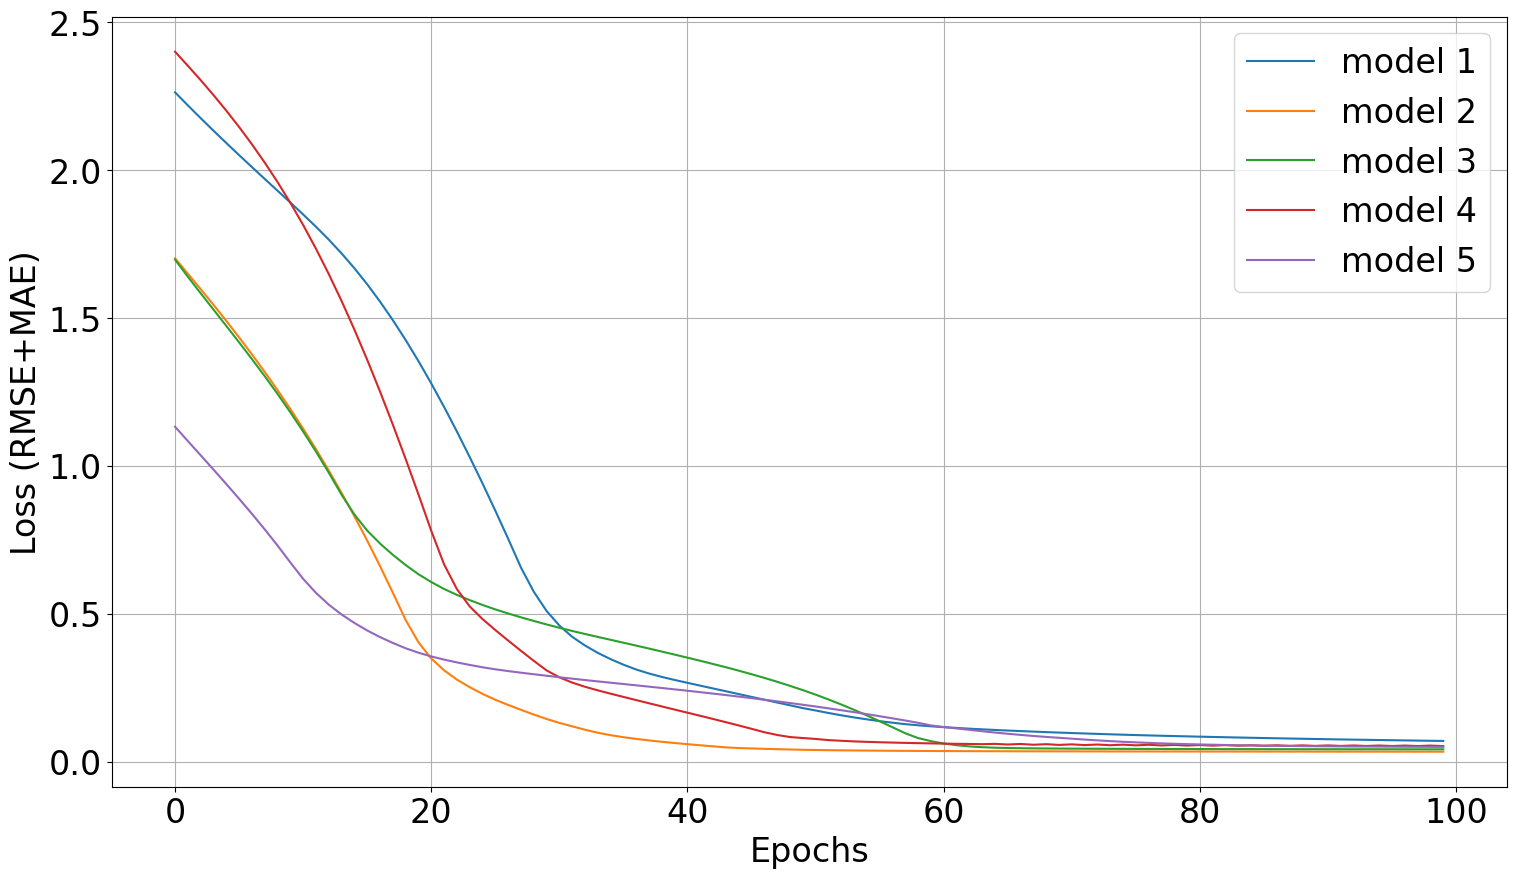

In [ ]:
plt.style.use("default")
matplotlib.rcParams.update({'font.size':24})
plt.figure(figsize=(18,10))
x = range(n_epochs)
plt.plot(x, ep)
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE+MAE)')
plt.grid(True)
plt.legend(ep.columns,loc='upper right')
plt.xticks(rotation="horizontal", ha="center")
plt.savefig("/content/LSTM.pdf",bbox_inches="tight")
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
len(test_loader)

6

In [94]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
all_predictions = []
testing= []
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs3, labels3 in test_loader:
            inputs3= inputs3.cuda()
            labels3 = labels3.cuda()
            output3= model(inputs3.float())
            predictions.append(output3.cpu().numpy())
            actu_test += labels3
            loss = criterion(output3.unsqueeze(1), labels3) +torch.sqrt(criterion2(output3.unsqueeze(1), labels3))
            test_loss += loss.item()

    # Store the predictions for this model
    print(f'Testing Loss:{test_loss/len(test_loader)}')
    testing.append(test_loss/len(test_loader))
    all_predictions.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions = np.mean(all_predictions, axis=0)
real3 = [tensor.item() for tensor in actu_test]

error=mean_squared_error(ensemble_predictions, real3)**0.5  + mean_absolute_error(ensemble_predictions,real3)
print(error)
print(testing)

Testing Loss:0.7838789920012156
Testing Loss:0.8204738795757294
Testing Loss:0.7851235866546631
Testing Loss:1.1018884380658467
Testing Loss:1.10997940103213
0.9036425431083023
[0.7838789920012156, 0.8204738795757294, 0.7851235866546631, 1.1018884380658467, 1.10997940103213]


In [95]:
print('Average training Loss: {:.4f}'.format(mean(losses)))
print('Average Validation Loss: {:.4f}'.format(mean(val_losses)))
print('Average Testing Loss: {:.4f}'.format(mean(testing)))
print(losses)
print(val_losses)
print(testing)

Average training Loss: 0.4035
Average Validation Loss: 0.5486
Average Testing Loss: 0.9203
[0.3395400047302246, 0.41387495398521423, 0.4926786422729492, 0.43246281147003174, 0.33908554911613464]
[0.8552561044692993, 0.49863789081573484, 0.2137634873390198, 0.4236986875534058, 0.7514723062515258]
[0.7838789920012156, 0.8204738795757294, 0.7851235866546631, 1.1018884380658467, 1.10997940103213]


In [ ]:
# save prediction for test set
RUL=pd.DataFrame(all_predictions).T
RUL

,0,1,2,3,4
0,0.211186,0.231104,0.236021,0.224569,0.221687
1,0.211034,0.231003,0.235951,0.224482,0.221532
2,0.210867,0.230885,0.235874,0.224381,0.221371
3,0.210752,0.230807,0.235825,0.224314,0.221263
4,0.210565,0.230709,0.235759,0.224222,0.221109
...,...,...,...,...,...
1394,-0.129069,0.004090,0.061526,0.112343,-0.033432
1395,-0.129356,0.003834,0.061414,0.112363,-0.033717
1396,-0.129443,0.003439,0.061251,0.112401,-0.034042
1397,-0.129717,0.003118,0.061113,0.112428,-0.034349


In [ ]:
#model on whole training set

train_loader=data.DataLoader(dataset=torch_dataset, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)

all_predictions2 = []
actu_test=[]
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss3 = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs4, labels4 in train_loader:
            inputs4 = inputs4.cuda()
            labels4 = labels4.cuda()
            output4 = model(inputs4.float())
            predictions.append(output4.cpu().numpy())
            actu_test += labels4
            loss = criterion(output4.unsqueeze(1), labels4) +torch.sqrt(criterion2(output4.unsqueeze(1), labels4))
            test_loss3 += loss.item()
    # Store the predictions for this model
    print(f'Training Loss:{test_loss3/(len(train_loader))}')

    all_predictions2.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions2 = np.mean(all_predictions2, axis=0)
real2 = [tensor.item() for tensor in actu_test]

error2=np.sqrt(mean_squared_error(ensemble_predictions2, real2))  + mean_absolute_error(ensemble_predictions2, real2)

print(error2)

Training Loss:0.051371758034371814
Training Loss:0.04896288656670114
Training Loss:0.05428468014882958
Training Loss:0.04828165038286344
Training Loss:0.04383489932945889
0.04868884388517003


<Axes: >

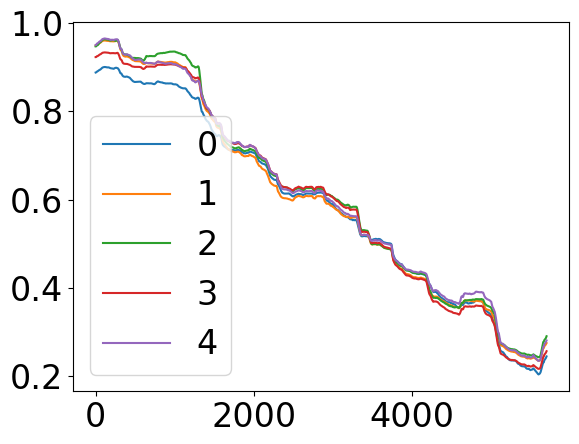

In [ ]:
RULT=pd.DataFrame(all_predictions2).T
RULT.plot()

In [ ]:
RUL.plot()

NameError: ignored

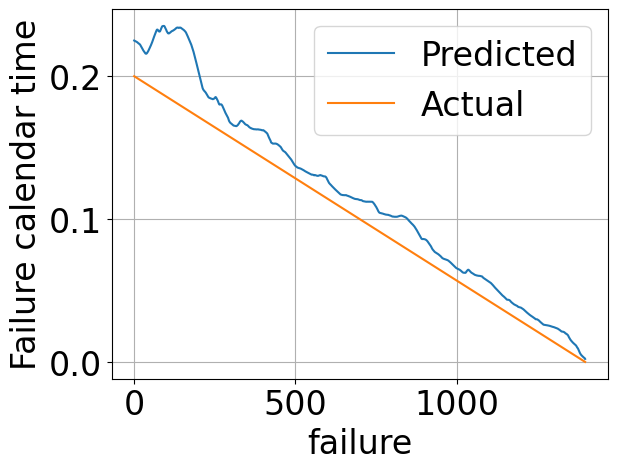

In [ ]:
plt.figsize=(16,9)
plt.plot(ensemble_predictions, label='Predicted')
plt.plot(real3, label='Actual')
plt.xlabel('failure')
plt.ylabel('Failure calendar time')
plt.grid()  # 生成网格
plt.legend()
plt.show()

# **CNN**

In [96]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(CNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layers, linear transformation
        self.fc1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Apply convolutional and pooling layers
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        # Reshape the output for the fully connected layer
        out = out.view(out.size(0), -1)

        # Apply fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out.squeeze()

In [97]:
model4 = CNN(input_size=len(dfr.columns), output_size=1, hidden_dim=4, n_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.0001

# Define Loss, Optimizer
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=lr, weight_decay=0.02)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

In [98]:
initialize_weights_xavier(model4)
model4.to(device)

CNN(
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [99]:
get_parameter_number(model4)

{'Total': 89, 'Trainable': 89}

In [104]:
from sklearn.model_selection import KFold
time = datetime.datetime.now()
# Define the number of folds
k = 5
set_seed(123)
torch.manual_seed(42)
# Initialize lists to store the losses and models
losses = []
val_losses = []
models = []
lossep = []
# Perform k-fold cross-validation
kf = KFold(n_splits=k, shuffle=False)
fold = 0
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()

In [105]:
# Split the data and target into k folds
for train_index, val_index in kf.split(torch_dataset):
    # Create train loader for the current fold
    train_subset = torch.utils.data.Subset(torch_dataset, train_index)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create validation loader for the current fold
    val_subset = torch.utils.data.Subset(torch_dataset, val_index)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Create a new instance of the model for each fold
    model =  CNN(input_size=len(dfr.columns), output_size=1, hidden_dim=4, n_layers=1)
    initialize_weights_xavier(model)

    model.cuda()
    model.train()
    # Define hyperparameters
    n_epochs = 100
    lr=0.001
    loss_sum = []
    # Define Loss, Optimizer

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = n_epochs, gamma = 0.1)

    # Train the model
    for epoch in range(1, n_epochs + 1):
        acc_loss = 0.
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = model(inputs.float())
            loss = criterion(output.unsqueeze(1), labels) + torch.sqrt(criterion2(output.unsqueeze(1), labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss

        loss_sum.append(acc_loss / len(train_loader))

        scheduler.step()
        if epoch % 20 == 0:
            print('Fold: {}/{} | Epoch: {}/{} | Loss: {:.4f}'.format(fold + 1, k, epoch, n_epochs, loss_sum[-1].item()))

    losses.append(loss_sum[-1].item()) #store average loss
    lossep.append(loss_sum) #store epoch loss

    # Validation
    model.eval()
    val_loss = 0.0
    total_samples2 = len(val_loader.dataset)
    with torch.no_grad():
        for inputs2, labels2 in val_loader:
            inputs2 = inputs2.cuda()
            labels2 = labels2.cuda()
            output2 = model(inputs2.float())
            loss2 = criterion(output2.unsqueeze(1), labels2) + torch.sqrt(criterion2(output2.unsqueeze(1), labels2))

            val_loss += loss2.item()

    val_loss_avg = val_loss / len(val_loader)

    print('Validation Loss: {:.4f}'.format(val_loss_avg))

    val_losses.append(val_loss_avg)
    models.append(model)
    fold += 1

print("Time={}".format(datetime.datetime.now()-time))

Fold: 1/5 | Epoch: 20/100 | Loss: 0.3272
Fold: 1/5 | Epoch: 40/100 | Loss: 0.2238
Fold: 1/5 | Epoch: 60/100 | Loss: 0.1124
Fold: 1/5 | Epoch: 80/100 | Loss: 0.0831
Fold: 1/5 | Epoch: 100/100 | Loss: 0.0776
Validation Loss: 0.2617
Fold: 2/5 | Epoch: 20/100 | Loss: 1.3035
Fold: 2/5 | Epoch: 40/100 | Loss: 0.6177
Fold: 2/5 | Epoch: 60/100 | Loss: 0.4386
Fold: 2/5 | Epoch: 80/100 | Loss: 0.4175
Fold: 2/5 | Epoch: 100/100 | Loss: 0.4143
Validation Loss: 0.5204
Fold: 3/5 | Epoch: 20/100 | Loss: 0.4986
Fold: 3/5 | Epoch: 40/100 | Loss: 0.3529
Fold: 3/5 | Epoch: 60/100 | Loss: 0.0648
Fold: 3/5 | Epoch: 80/100 | Loss: 0.0602
Fold: 3/5 | Epoch: 100/100 | Loss: 0.0587
Validation Loss: 0.0734
Fold: 4/5 | Epoch: 20/100 | Loss: 0.3677
Fold: 4/5 | Epoch: 40/100 | Loss: 0.2238
Fold: 4/5 | Epoch: 60/100 | Loss: 0.1078
Fold: 4/5 | Epoch: 80/100 | Loss: 0.0775
Fold: 4/5 | Epoch: 100/100 | Loss: 0.0753
Validation Loss: 0.0506
Fold: 5/5 | Epoch: 20/100 | Loss: 0.3185
Fold: 5/5 | Epoch: 40/100 | Loss: 0.240

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
def to_matrix(l, n):
   return [l[i:i+n] for i in range(0, len(l), n)]

In [ ]:
#On testing set

ep=flatten(lossep)

ep = [tensor.item() for tensor in ep]

In [ ]:
ep=pd.DataFrame(np.array(ep).reshape(5,100).T)

In [ ]:
ep.columns=['model 1','model 2','model 3','model 4','model 5'] #,'model 6','model 7','model 8','model 9','model 10']

In [ ]:
ep.to_csv("/content/ep.csv")

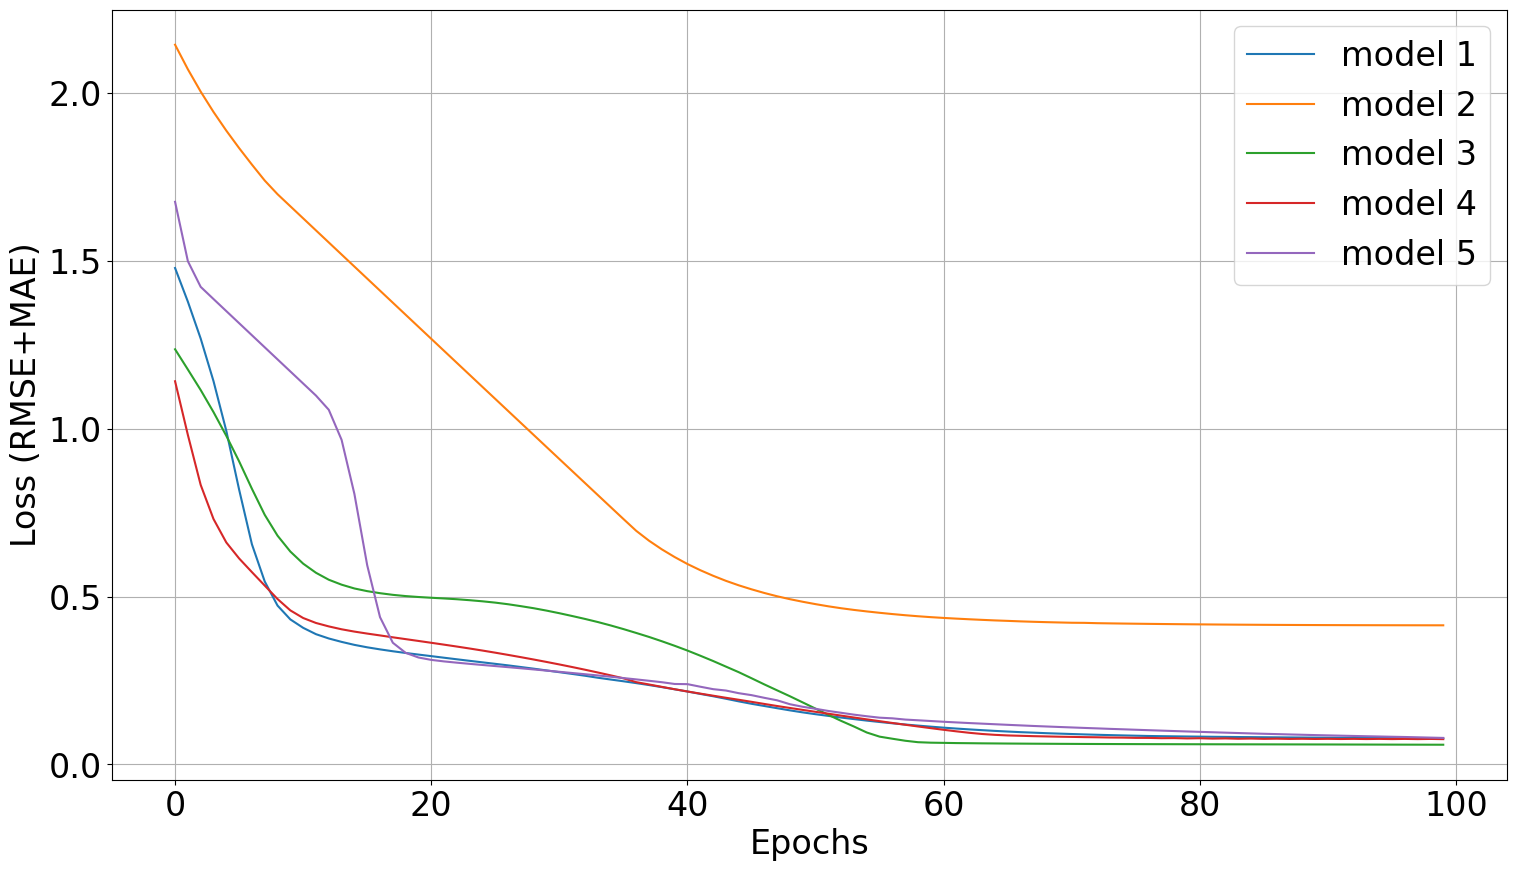

In [ ]:
plt.style.use("default")
matplotlib.rcParams.update({'font.size':24})
plt.figure(figsize=(18,10))
x = range(n_epochs)
plt.plot(x, ep)
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE+MAE)')
plt.grid(True)
plt.legend(ep.columns,loc='upper right')
plt.xticks(rotation="horizontal", ha="center")
plt.savefig("/content/CNN.pdf",bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
len(test_loader)

6

In [106]:
test_loader=data.DataLoader(dataset=torch_dataset2, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)
all_predictions = []
testing= []
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs3, labels3 in test_loader:
            inputs3= inputs3.cuda()
            labels3 = labels3.cuda()
            output3= model(inputs3.float())
            predictions.append(output3.cpu().numpy())
            actu_test += labels3
            loss = criterion(output3.unsqueeze(1), labels3) +torch.sqrt(criterion2(output3.unsqueeze(1), labels3))
            test_loss += loss.item()

    # Store the predictions for this model
    print(f'Testing Loss:{test_loss/len(test_loader)}')
    testing.append(test_loss/len(test_loader))
    all_predictions.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions = np.mean(all_predictions, axis=0)
real3 = [tensor.item() for tensor in actu_test]

error=mean_squared_error(ensemble_predictions, real3)**0.5  + mean_absolute_error(ensemble_predictions,real3)
print(error)
print(testing)

Testing Loss:0.12983074908455214
Testing Loss:0.7987180749575297
Testing Loss:0.2330368608236313
Testing Loss:0.2006603709111611
Testing Loss:0.5844268302122752
0.3829702766987849
[0.12983074908455214, 0.7987180749575297, 0.2330368608236313, 0.2006603709111611, 0.5844268302122752]


In [107]:
print('Average training Loss: {:.4f}'.format(mean(losses)))
print('Average Validation Loss: {:.4f}'.format(mean(val_losses)))
print('Average Testing Loss: {:.4f}'.format(mean(testing)))
print(losses)
print(val_losses)
print(testing)

Average training Loss: 0.1410
Average Validation Loss: 0.2307
Average Testing Loss: 0.3893
[0.07760647684335709, 0.4143263101577759, 0.05869527533650398, 0.07533617317676544, 0.07920573651790619]
[0.2616509675979614, 0.5203897297382355, 0.07343223243951798, 0.05060307048261166, 0.2475542664527893]
[0.12983074908455214, 0.7987180749575297, 0.2330368608236313, 0.2006603709111611, 0.5844268302122752]


In [ ]:
# save prediction for test set
RUL=pd.DataFrame(all_predictions).T
RUL

,0,1,2,3,4
0,0.507456,0.503485,0.382018,0.667263,0.667378
1,0.507456,0.503544,0.382731,0.667263,0.667378
2,0.507456,0.503572,0.383078,0.667263,0.667378
3,0.507456,0.503607,0.383512,0.667263,0.667378
4,0.507456,0.503636,0.383888,0.667263,0.667378
...,...,...,...,...,...
1480,0.507456,0.500840,0.252990,0.667263,0.667378
1481,0.507456,0.500837,0.253137,0.667263,0.667378
1482,0.507456,0.500853,0.253482,0.667263,0.667378
1483,0.507456,0.500858,0.253681,0.667263,0.667378


In [ ]:
#model on whole training set

train_loader=data.DataLoader(dataset=torch_dataset, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)

all_predictions2 = []
actu_test=[]
for model in models:
    model.eval()
    predictions = []
    actu_test=[]
    test_loss3 = 0.0
    # Iterate over the test data
    with torch.no_grad():
        for inputs4, labels4 in train_loader:
            inputs4 = inputs4.cuda()
            labels4 = labels4.cuda()
            output4 = model(inputs4.float())
            predictions.append(output4.cpu().numpy())
            actu_test += labels4
            loss = criterion(output4.unsqueeze(1), labels4) +torch.sqrt(criterion2(output4.unsqueeze(1), labels4))
            test_loss3 += loss.item()
    # Store the predictions for this model
    print(f'Training Loss:{test_loss3/(len(train_loader))}')

    all_predictions2.append(np.concatenate(predictions))

# Perform ensemble by averaging the predictions from all models
ensemble_predictions2 = np.mean(all_predictions2, axis=0)
real2 = [tensor.item() for tensor in actu_test]

error2=np.sqrt(mean_squared_error(ensemble_predictions2, real2))  + mean_absolute_error(ensemble_predictions2, real2)

print(error2)

Training Loss:0.42827395365263027
Training Loss:0.387123820449536
Training Loss:0.09146844580148657
Training Loss:0.42919257779916126
Training Loss:0.429236915272971
0.34622806930884553


<Axes: >

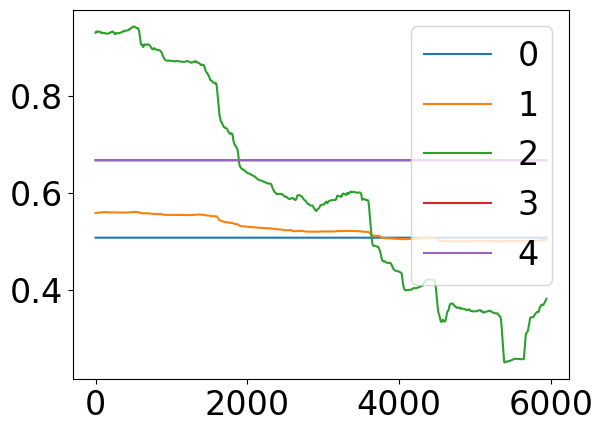

In [ ]:
RULT=pd.DataFrame(all_predictions2).T
RULT.plot()

<Axes: >

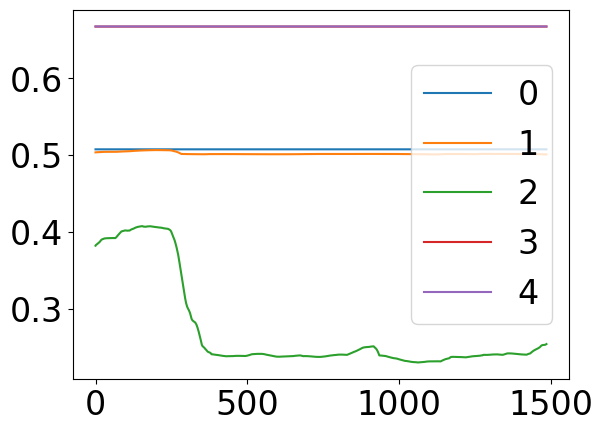

In [ ]:
RUL.plot()

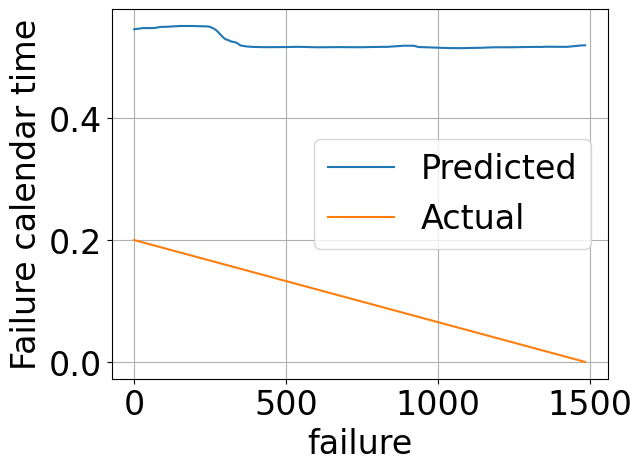

In [ ]:
plt.figsize=(16,9)
plt.plot(ensemble_predictions, label='Predicted')
plt.plot(real3, label='Actual')
plt.xlabel('failure')
plt.ylabel('Failure calendar time')
plt.grid()  # 生成网格
plt.legend()
plt.show()

# **BNN**

In [51]:
def chunk(length, num_parts):
  chunk_size = length // num_parts
  xx = [chunk_size * ((i)+1) for i in range(num_parts)]
  return xx

In [52]:
df_concatenated = pd.concat([RULT, RUL], axis=0)
df_concatenated.index=dfr.index
dfb=df_concatenated
dfb.index = pd.to_datetime(dfb.index, utc=True)

averages = dfb.mean(axis=1)
dfb.columns=['model 1',"model 2","model 3","model 4", "model 5"]
dfb['average'] = averages
dfb

,model 1,model 2,model 3,model 4,model 5,average
Timestamp,,,,,,
2016-05-31 13:00:00+00:00,0.998957,0.984923,1.001612,0.977090,0.981410,0.988798
2016-05-31 13:10:00+00:00,0.998500,0.984439,1.001097,0.976697,0.981015,0.988349
2016-05-31 13:20:00+00:00,0.998052,0.983944,1.000548,0.976277,0.980640,0.987892
2016-05-31 13:30:00+00:00,0.997436,0.983288,0.999741,0.975706,0.980110,0.987256
2016-05-31 13:40:00+00:00,0.996965,0.982767,0.999183,0.975273,0.979734,0.986784
...,...,...,...,...,...,...
2016-07-18 01:40:00+00:00,-0.155993,-0.049756,0.074583,0.128352,-0.078906,-0.016344
2016-07-18 01:50:00+00:00,-0.155798,-0.049999,0.074488,0.128402,-0.079123,-0.016406
2016-07-18 02:00:00+00:00,-0.155638,-0.050805,0.074125,0.128482,-0.079813,-0.016730


In [53]:
dfb.to_csv("dfb.csv")

In [108]:
dfb=pd.read_csv("dfb.csv",index_col=0)
dfb.index = pd.to_datetime(dfb.index, utc=True)
dfb

,model 1,model 2,model 3,model 4,model 5,average
Timestamp,,,,,,
2016-05-31 13:00:00+00:00,0.998957,0.984923,1.001612,0.977090,0.981410,0.988798
2016-05-31 13:10:00+00:00,0.998500,0.984439,1.001097,0.976697,0.981015,0.988349
2016-05-31 13:20:00+00:00,0.998053,0.983944,1.000548,0.976277,0.980640,0.987892
2016-05-31 13:30:00+00:00,0.997436,0.983288,0.999741,0.975706,0.980110,0.987256
2016-05-31 13:40:00+00:00,0.996965,0.982767,0.999183,0.975273,0.979734,0.986784
...,...,...,...,...,...,...
2016-07-18 01:40:00+00:00,-0.155993,-0.049756,0.074583,0.128352,-0.078906,-0.016344
2016-07-18 01:50:00+00:00,-0.155798,-0.049999,0.074488,0.128402,-0.079123,-0.016406
2016-07-18 02:00:00+00:00,-0.155638,-0.050805,0.074125,0.128482,-0.079813,-0.016730


6847
[[1.00000000e+00]
 [9.99853972e-01]
 [9.99707944e-01]
 ...
 [2.92056075e-04]
 [1.46028037e-04]
 [0.00000000e+00]]


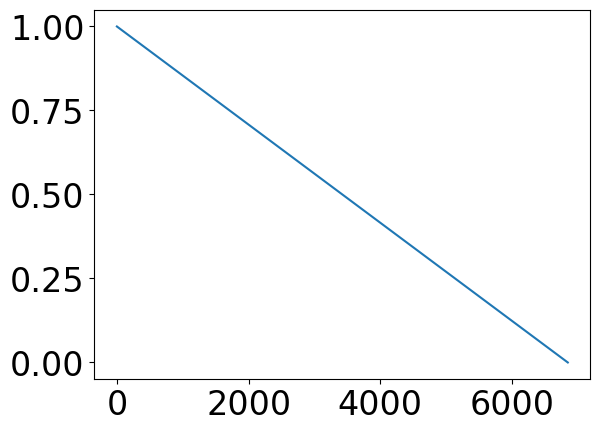

In [109]:
target=((datetime.datetime(2016, 7, 18,2,20,0)-pd.to_datetime(dfb.index.values)).total_seconds() / (3600)).values #hours

target = (target-min(target)) /(max(target)-min(target))

target=np.reshape(target,(len(dfb),1))

print(len(target))
print(target)
plt.plot(target)

In [110]:
train, test = train_test_split(dfb, test_size=0.2,shuffle=False)
a_o, b_o = train_test_split(target, test_size=0.2,shuffle=False)

train_shape=train.shape[0]
test_shape=test.shape[0]
a=train.to_numpy()
a=np.reshape(a,(len(a),len(dfb.columns)))
b=test.to_numpy()
b=np.reshape(b,(len(b),len(dfb.columns)))
input_seq = torch.from_numpy(a)
target_seq = torch.Tensor(a_o)
input_seq2 = torch.from_numpy(b)
target_seq2 = torch.Tensor(b_o)
torch_dataset3=data.TensorDataset(input_seq,target_seq)
torch_dataset4=data.TensorDataset(input_seq2,target_seq2)

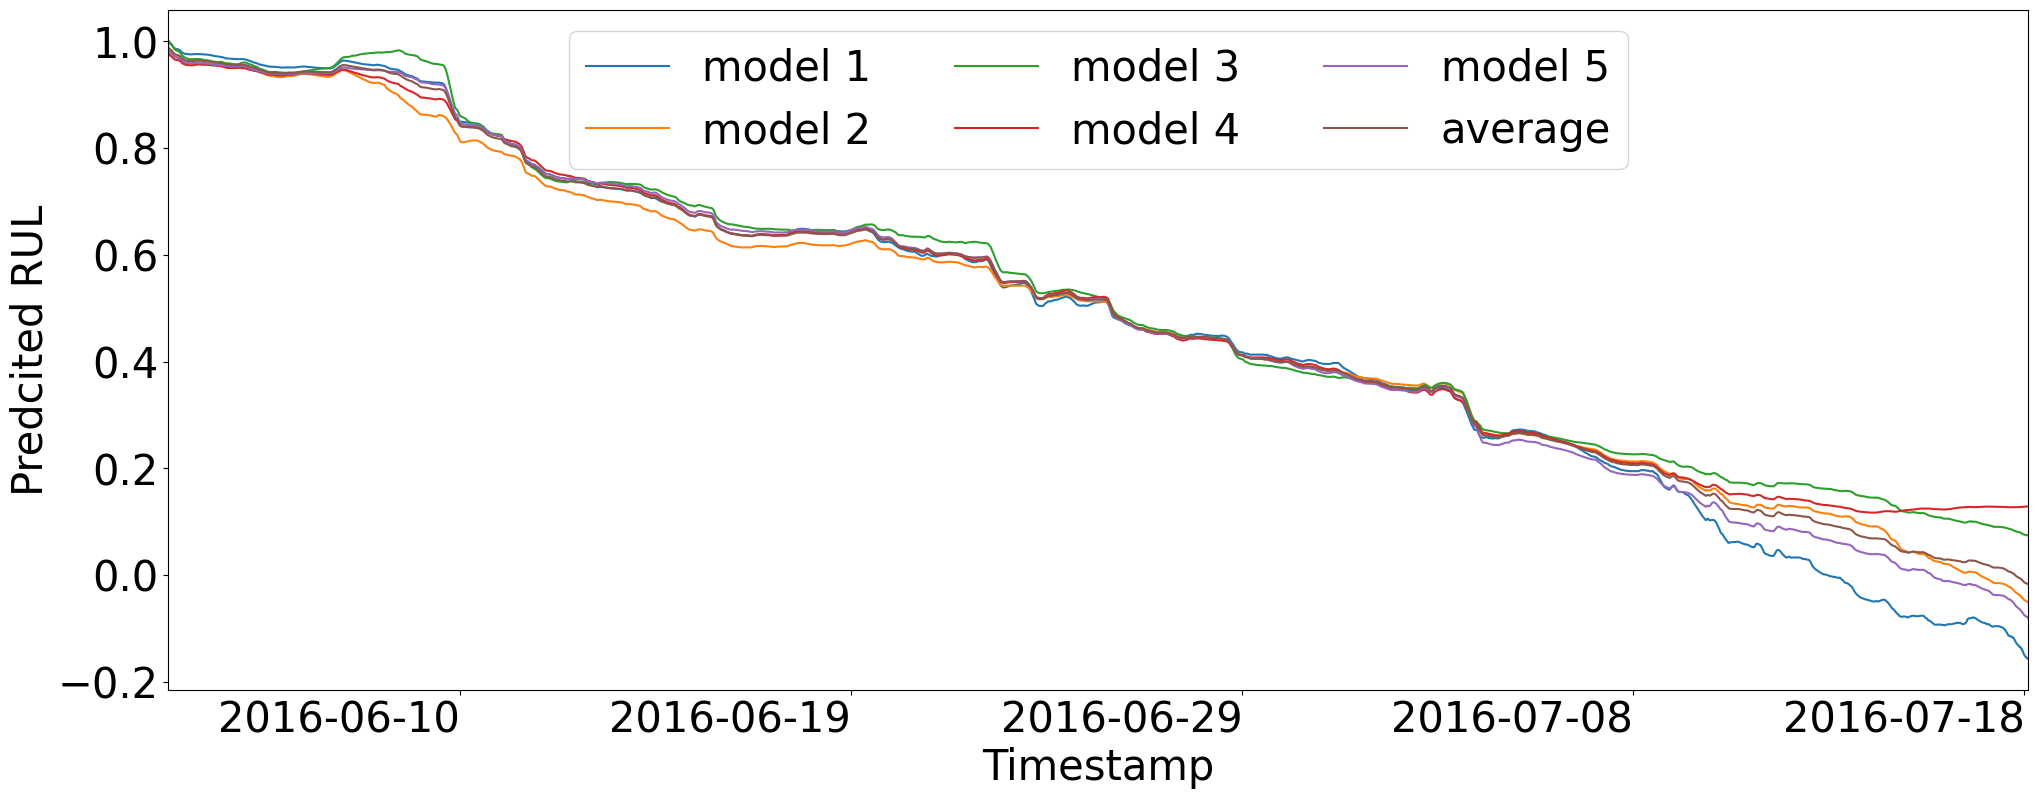

In [112]:
#csfont = {'fontname':'Charis SIL'}
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 30})
# Convert the index to a formatted string (e.g., '%Y-%m-%d')
x = pd.to_datetime(dfb.index, format="%Y-%m-%d").strftime('%Y-%m-%d')
length = train_shape + test_shape

num_parts = 5  # Number of parts
xx_indices = chunk(length, num_parts)
xx = pd.to_datetime(dfb.index[xx_indices]).strftime('%Y-%m-%d').tolist()

plt.figure(figsize=(24, 10))
ax = plt.gca()

# Plot the DataFrame 'dfb' and create legends for each column
for column in dfb.columns:
    dfb[column].plot(ax=ax, label=column)

plt.margins(x=0)
plt.legend(loc="upper center", ncol=3, fontsize=30)

# Set x-axis tick positions and labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5, prune="both"))
a = ax.get_xticks()
plt.xticks(a, xx, rotation="horizontal", ha="right")

plt.xlabel('Timestamp', **csfont)
plt.ylabel('Predcited RUL', **csfont)

plt.savefig('/content/dfb.pdf', bbox_inches='tight')
plt.show()

In [113]:
pip install torchbnn

In [114]:
import torch as T
import torchbnn as bnn

device = T.device("cuda")

class BayesianNet(T.nn.Module):

    def __init__(self, input_size):
        super(BayesianNet, self).__init__()

        self.hid1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,in_features=input_size, out_features=2, bias=True)

        self.hid2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,in_features=2, out_features=2, bias=True)

        self.hid3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,in_features=2, out_features=1, bias=True)

        self.re = nn.ReLU(inplace=True)

    def forward(self, x):

        x_hid1 = self.hid1(x)
        x_hid2 = self.hid2(x_hid1)
        x_hid3 = self.hid3(x_hid2)
        xx = self.re(x_hid3)

        return xx

In [115]:
ce_loss = T.nn.CrossEntropyLoss()   # applies softmax()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

In [116]:
# Define hyperparameters
n_epochs = 250
lr= 0.01
losses = []
val_losses = []
models = []
# Define Loss, Optimizer
criterion = nn.L1Loss()
criterion2 = nn.MSELoss()

In [117]:
modelB = BayesianNet(len(dfb.columns))
print(modelB)

BayesianNet(
  (hid1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=6, out_features=2, bias=True)
  (hid2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=2, bias=True)
  (hid3): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=1, bias=True)
  (re): ReLU(inplace=True)
)


In [118]:
print(get_parameter_number(modelB))
type(torch_dataset3)
from sklearn.model_selection import KFold
from torch.utils.data import Subset

{'Total': 46, 'Trainable': 46}


In [119]:
n_folds = 5  # Number of folds for K-fold cross-validation
time = datetime.datetime.now()
kf = KFold(n_splits=n_folds, shuffle=False)

for fold, (train_index, val_index) in enumerate(kf.split(torch_dataset3)):
    train_dataset = Subset(torch_dataset3, train_index)
    val_dataset = Subset(torch_dataset3, val_index)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = data.DataLoader(dataset=val_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    model = BayesianNet(len(dfb.columns))  # Create your model instance here
    initialize_weights_xavier(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_sum = []
    for epoch in range(1, n_epochs + 1):
        acc_loss = 0.
        # Training
        model.train()
        for i, (inputsB, labelsB) in enumerate(train_loader):
            model.cuda()
            inputsB = inputsB.cuda()
            labelsB = labelsB.cuda()
            outputB = model(inputsB.float())

            loss = torch.sqrt(criterion2(outputB, labelsB)) + criterion(outputB, labelsB)
            kll = kl_loss(model)
            tot_loss = loss + 0.01 * kll
            acc_loss += tot_loss.item()

            optimizer.zero_grad()
            tot_loss.backward()
            optimizer.step()

        avg_loss = acc_loss / (i + 1)
        loss_sum.append(acc_loss / len(train_loader))
        if epoch % 100 == 0:
            print('Fold: {}/{} | Epoch: {}/{} | Loss: {:.4f}'.format(fold + 1, n_folds, epoch, n_epochs, loss_sum[-1]))

    losses.append(loss_sum[-1])
    # Validation
    model.eval()
    val_loss = 0.
    with torch.no_grad():
      for inputsB, labelsB in val_loader:
        inputsB = inputsB.cuda()
        labelsB = labelsB.cuda()
        outputB = model(inputsB.float())
        loss = torch.sqrt(criterion2(outputB, labelsB)) + criterion(outputB, labelsB)
        val_loss += loss.item()+ 0.01*kl_loss(model)
        avg_val_loss = val_loss.item() / len(val_loader)


    print('Validation Loss: {:.4f}'.format(avg_val_loss))
    # Store the loss and model for the fold

    val_losses.append(avg_val_loss)
    models.append(model)
    fold += 1

print('Average training Loss: {:.4f}'.format(sum(losses)/ n_folds))
print('Average Validation Loss: {:.4f}'.format(sum(val_losses) / n_folds))
print("Time={}".format(datetime.datetime.now()-time))

Fold: 1/5 | Epoch: 100/250 | Loss: 0.1107
Fold: 1/5 | Epoch: 200/250 | Loss: 0.1008
Validation Loss: 0.1360
Fold: 2/5 | Epoch: 100/250 | Loss: 0.0946
Fold: 2/5 | Epoch: 200/250 | Loss: 0.0936
Validation Loss: 0.1398
Fold: 3/5 | Epoch: 100/250 | Loss: 0.1164
Fold: 3/5 | Epoch: 200/250 | Loss: 0.1078
Validation Loss: 0.0838
Fold: 4/5 | Epoch: 100/250 | Loss: 0.1253
Fold: 4/5 | Epoch: 200/250 | Loss: 0.1152
Validation Loss: 0.1091
Fold: 5/5 | Epoch: 100/250 | Loss: 0.1295
Fold: 5/5 | Epoch: 200/250 | Loss: 0.1148
Validation Loss: 0.0855
Average training Loss: 0.1082
Average Validation Loss: 0.1109
Time=0:07:34.571659


In [120]:
# Training Run
modelB = BayesianNet(len(dfb.columns))
initialize_weights_xavier(modelB)
modelB.to(device)
optimizer = torch.optim.Adam(modelB.parameters(), lr=lr)
loss_sum = []
time = datetime.datetime.now()

train_loader3=data.DataLoader(dataset=torch_dataset3, batch_size=256, shuffle=True,num_workers=2,pin_memory=True)

for epoch in range(1, n_epochs + 1):
    acc_loss = 0.
    for i, (inputsB,labelsB) in enumerate(train_loader3):
        modelB.cuda()
        inputsB = inputsB.cuda() #100x6
        labelsB = labelsB.cuda() #100x1

        outputB= modelB(inputsB.float()) #100x1

        loss = torch.sqrt(criterion2(outputB, labelsB))+criterion(outputB, labelsB)

        kll = kl_loss(modelB)       # distribution loss
        tot_loss = loss + 0.01*kll
        acc_loss += tot_loss

        optimizer.zero_grad()
        tot_loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly

    loss_sum.append(acc_loss /(i+1))

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_sum[epoch-1].item()))

print("Time={}".format(datetime.datetime.now()-time))

Epoch: 10/250............. Loss: 0.2865
Epoch: 20/250............. Loss: 0.1809
Epoch: 30/250............. Loss: 0.1907
Epoch: 40/250............. Loss: 0.1587
Epoch: 50/250............. Loss: 0.1328
Epoch: 60/250............. Loss: 0.1190
Epoch: 70/250............. Loss: 0.1636
Epoch: 80/250............. Loss: 0.1216
Epoch: 90/250............. Loss: 0.1152
Epoch: 100/250............. Loss: 0.1128
Epoch: 110/250............. Loss: 0.1150
Epoch: 120/250............. Loss: 0.1188
Epoch: 130/250............. Loss: 0.1323
Epoch: 140/250............. Loss: 0.1161
Epoch: 150/250............. Loss: 0.1104
Epoch: 160/250............. Loss: 0.1089
Epoch: 170/250............. Loss: 0.1124
Epoch: 180/250............. Loss: 0.1116
Epoch: 190/250............. Loss: 0.1151
Epoch: 200/250............. Loss: 0.1080
Epoch: 210/250............. Loss: 0.1100
Epoch: 220/250............. Loss: 0.1082
Epoch: 230/250............. Loss: 0.1135
Epoch: 240/250............. Loss: 0.1092
Epoch: 250/250...........

In [121]:
torch.save(modelB, "/content/BNNFI.pt")

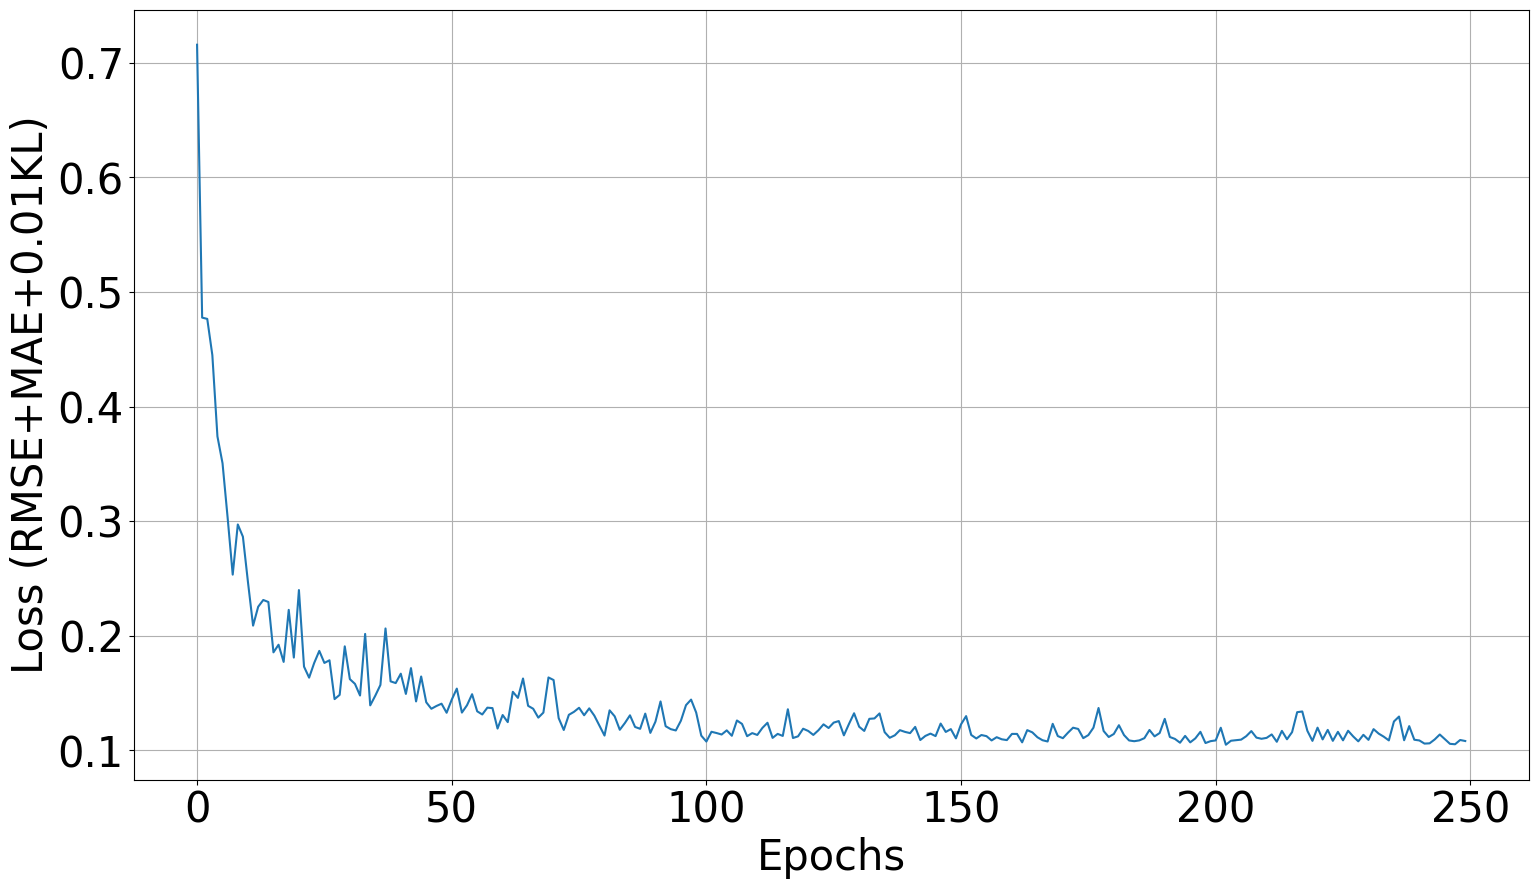

In [122]:
#Loss for calculating KL divergence of baysian neural network model.
plt.figure(figsize=(18,10))
x = range(n_epochs)
y = [tensor.item() for tensor in loss_sum]
plt.plot(x, y)
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE+MAE+0.01KL)')
plt.xticks(rotation="horizontal", ha="center")
plt.grid()
plt.savefig("/content/BNN.pdf",bbox_inches="tight")

In [123]:
test_loss = 0.0
pred_test=[]
actu_test=[]

test_loader4=data.DataLoader(dataset=torch_dataset4, batch_size=test_shape, shuffle=False,num_workers=2,pin_memory=True)

modelB.eval()

with torch.no_grad():
    for i, (inputs4B,labels4B) in enumerate(test_loader4):
      inputs4 = inputs4B.cuda()
      labels4 = labels4B.cuda()

      print(len(labels4))

      output4= [np.squeeze(modelB(inputs4.float())) for _ in range(5000)]
      pred_test += output4
      actu_test += labels4
      kll = kl_loss(modelB)       # distribution loss
      tot_loss = 0.01 * kll
      test_loss += tot_loss

print(f'Testing Loss:{test_loss.item()/(len(test_loader4))}')

1370
Testing Loss:0.05108124017715454


In [124]:
test_loss2 = 0.0
pred_test2=[]
actu_test2=[]

test_loader3=data.DataLoader(dataset=torch_dataset3, batch_size=train_shape, shuffle=False,num_workers=2,pin_memory=True)

modelB.eval()

with torch.no_grad():
    for i, (inputs3B,labels3B) in enumerate(test_loader3):
      inputs3 = inputs3B.cuda()
      labels3 = labels3B.cuda()
      output3= [np.squeeze(modelB(inputs3.float())) for _ in range(5000)]

      pred_test2 += output3
      actu_test2 += labels3

      print(len(labels3))
      #loss = torch.sqrt(criterion2(output3, labels3))#riterion(output, labels)

        #cel = ce_loss(output, labels.float())   # regular loss

      kll = kl_loss(modelB)       # distribution loss
      tot_loss = 0.01 * kll
      test_loss2 += tot_loss

print(f'Training Loss:{test_loss2.item()/(len(test_loader3))}')

5477
Training Loss:0.05108124017715454


In [125]:
prediction3 = [tensor for tensor in pred_test]
real3 = [tensor.item() for tensor in actu_test]

prediction4 = [tensor for tensor in pred_test2]
real4 = [tensor.item() for tensor in actu_test2]

In [126]:
prediction3 = [t.cpu().numpy() for t in prediction3]
c=pd.DataFrame(np.row_stack(prediction3))
c

,0,1,2,3,4,5,6,7,8,9,...,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369
0,0.203436,0.202964,0.202506,0.202077,0.201550,0.200836,0.200058,0.199383,0.198762,0.198201,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.192305,0.191852,0.191412,0.191000,0.190494,0.189808,0.189062,0.188414,0.187818,0.187277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.208634,0.208173,0.207726,0.207307,0.206793,0.206095,0.205338,0.204680,0.204074,0.203526,...,0.002405,0.002172,0.002123,0.001891,0.001654,0.001404,0.001351,0.001058,0.000803,0.000236
3,0.190515,0.190061,0.189621,0.189209,0.188703,0.188017,0.187270,0.186622,0.186026,0.185486,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.200589,0.200135,0.199693,0.199280,0.198773,0.198084,0.197336,0.196686,0.196088,0.195547,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.195669,0.195214,0.194772,0.194359,0.193852,0.193163,0.192414,0.191765,0.191166,0.190625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4996,0.197661,0.197189,0.196730,0.196301,0.195775,0.195059,0.194282,0.193607,0.192986,0.192426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4997,0.196446,0.195997,0.195561,0.195153,0.194652,0.193972,0.193234,0.192593,0.192002,0.191469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4998,0.213093,0.212614,0.212150,0.211714,0.211181,0.210457,0.209670,0.208987,0.208358,0.207791,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [127]:
prediction4 = [t.cpu().numpy() for t in prediction4]
c2=pd.DataFrame(np.row_stack(prediction4))
c2

,0,1,2,3,4,5,6,7,8,9,...,5467,5468,5469,5470,5471,5472,5473,5474,5475,5476
0,0.957311,0.956884,0.956450,0.955847,0.955398,0.954888,0.954467,0.954036,0.953767,0.953196,...,0.202084,0.201841,0.201636,0.201221,0.200800,0.200603,0.200388,0.199995,0.199728,0.199287
1,0.946794,0.946373,0.945943,0.945347,0.944904,0.944400,0.943982,0.943556,0.943288,0.942723,...,0.201877,0.201637,0.201436,0.201026,0.200611,0.200416,0.200205,0.199817,0.199555,0.199120
2,0.943930,0.943507,0.943076,0.942478,0.942034,0.941529,0.941112,0.940685,0.940419,0.939853,...,0.197128,0.196888,0.196687,0.196277,0.195862,0.195667,0.195455,0.195067,0.194805,0.194370
3,0.988574,0.988138,0.987693,0.987075,0.986616,0.986094,0.985663,0.985222,0.984946,0.984361,...,0.218258,0.218012,0.217803,0.217383,0.216957,0.216755,0.216537,0.216139,0.215869,0.215422
4,0.961525,0.961093,0.960655,0.960045,0.959591,0.959076,0.958651,0.958215,0.957944,0.957366,...,0.199201,0.198957,0.198751,0.198333,0.197909,0.197710,0.197494,0.197098,0.196830,0.196386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.979149,0.978711,0.978265,0.977645,0.977184,0.976659,0.976226,0.975783,0.975506,0.974919,...,0.204400,0.204151,0.203940,0.203515,0.203085,0.202882,0.202661,0.202259,0.201986,0.201534
4996,0.960307,0.959877,0.959441,0.958835,0.958384,0.957871,0.957448,0.957015,0.956744,0.956171,...,0.200138,0.199893,0.199687,0.199268,0.198844,0.198645,0.198429,0.198032,0.197764,0.197320
4997,0.968192,0.967760,0.967321,0.966712,0.966258,0.965742,0.965318,0.964883,0.964612,0.964036,...,0.202174,0.201927,0.201719,0.201296,0.200868,0.200667,0.200448,0.200048,0.199776,0.199328
4998,0.943511,0.943089,0.942661,0.942065,0.941622,0.941119,0.940704,0.940279,0.940014,0.939450,...,0.198131,0.197892,0.197691,0.197282,0.196867,0.196672,0.196461,0.196073,0.195811,0.195377


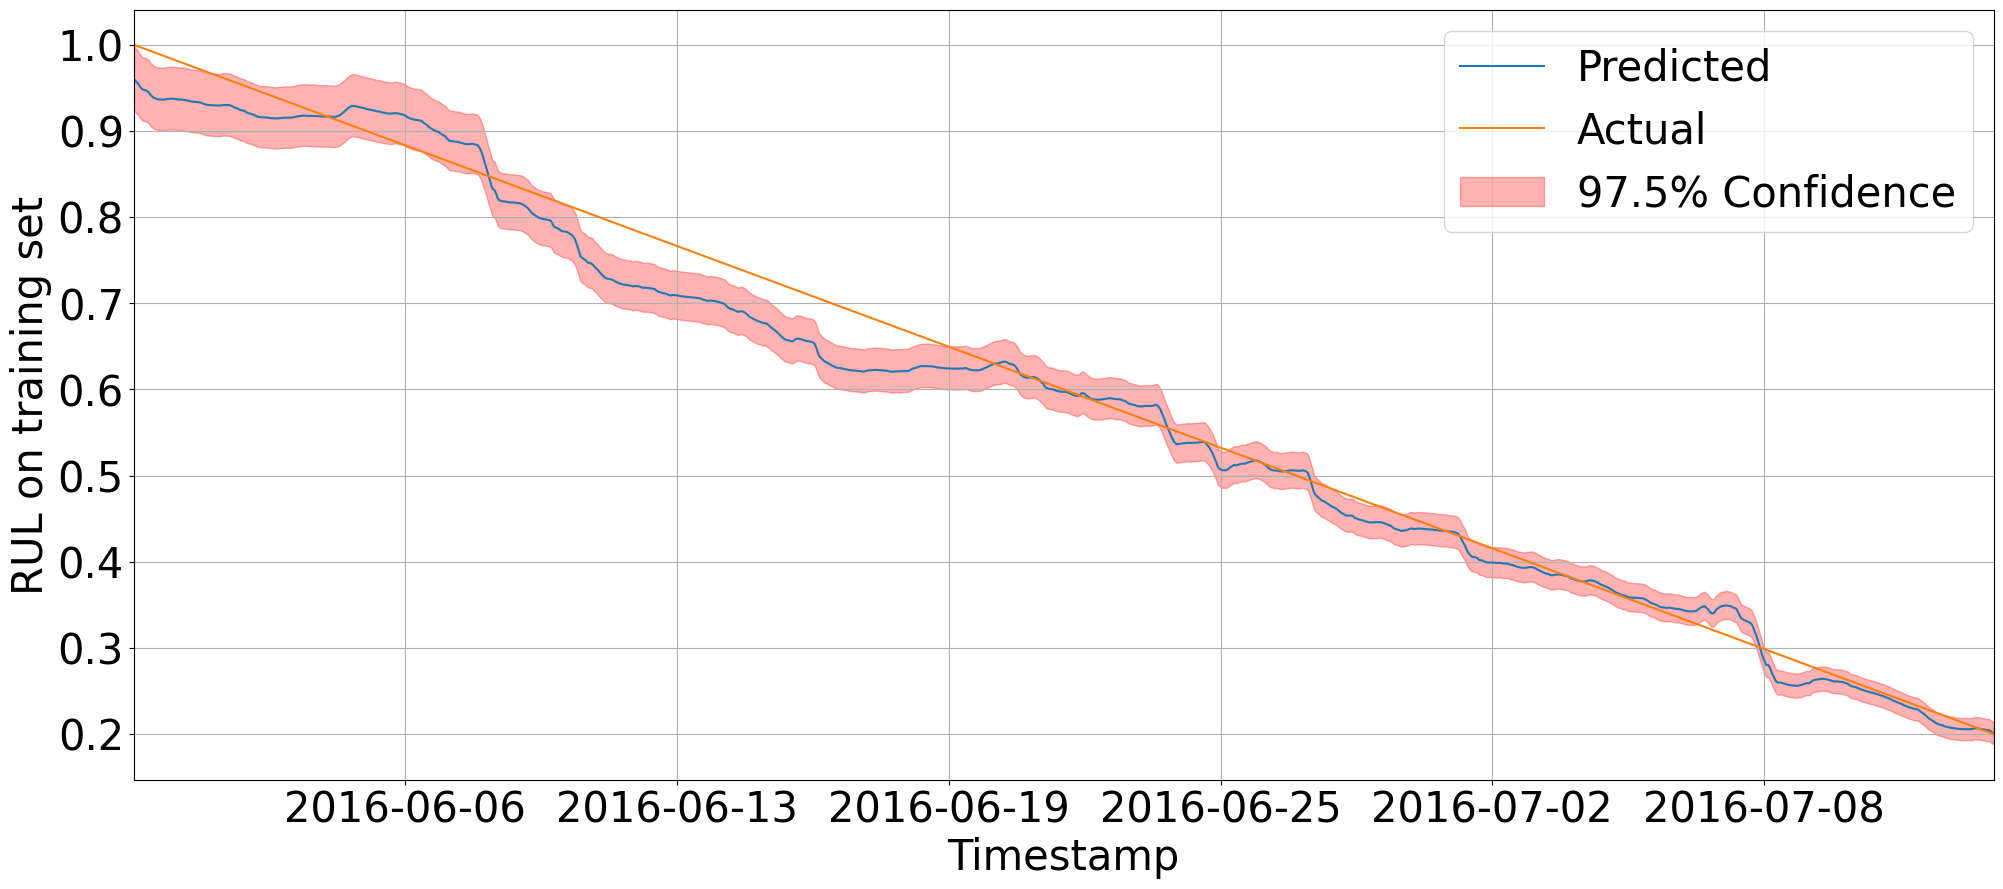

In [128]:
import matplotlib.ticker as ticker
plt.figure(figsize=(24,10))
ax = plt.gca()
x = pd.to_datetime(train.index, format="%Y-%m-%d").strftime('%Y-%m-%d')
length = train_shape
num_parts = 6 # Number of parts

xx_indices = chunk(length,num_parts)

xx = pd.to_datetime(train.index[xx_indices]).strftime('%Y-%m-%d').tolist()
plt.margins(x=0)
#y = [tensor.item() for tensor in loss_sum]
plt.plot(np.mean(c2, axis=0), label='Predicted')
plt.plot(real4, label='Actual')

plt.fill_between(list(range(len(real4))),np.percentile(c2, 2.5, axis=0), np.percentile(c2, 97.5, axis=0), color='r', alpha=0.3, label='97.5% Confidence')

ax.xaxis.set_major_locator(plt.MaxNLocator(8,prune ="both"))

a= ax.get_xticks()

plt.xlabel('Timestamp')
plt.ylabel('RUL on training set')
plt.legend()

plt.xticks(a,xx,rotation="horizontal", ha="center")

plt.grid()  # 生成网格
plt.savefig("/content/FinalRUL.pdf",bbox_inches="tight")

In [129]:
real5=real4+real3

In [130]:
c3=pd.concat([c2, c], axis=1, join="inner")
c3.columns = list(range(train_shape+test_shape))
c3

,0,1,2,3,4,5,6,7,8,9,...,6837,6838,6839,6840,6841,6842,6843,6844,6845,6846
0,0.957311,0.956884,0.956450,0.955847,0.955398,0.954888,0.954467,0.954036,0.953767,0.953196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.946794,0.946373,0.945943,0.945347,0.944904,0.944400,0.943982,0.943556,0.943288,0.942723,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.943930,0.943507,0.943076,0.942478,0.942034,0.941529,0.941112,0.940685,0.940419,0.939853,...,0.002405,0.002172,0.002123,0.001891,0.001654,0.001404,0.001351,0.001058,0.000803,0.000236
3,0.988574,0.988138,0.987693,0.987075,0.986616,0.986094,0.985663,0.985222,0.984946,0.984361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.961525,0.961093,0.960655,0.960045,0.959591,0.959076,0.958651,0.958215,0.957944,0.957366,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.979149,0.978711,0.978265,0.977645,0.977184,0.976659,0.976226,0.975783,0.975506,0.974919,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4996,0.960307,0.959877,0.959441,0.958835,0.958384,0.957871,0.957448,0.957015,0.956744,0.956171,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4997,0.968192,0.967760,0.967321,0.966712,0.966258,0.965742,0.965318,0.964883,0.964612,0.964036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4998,0.943511,0.943089,0.942661,0.942065,0.941622,0.941119,0.940704,0.940279,0.940014,0.939450,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [131]:
c3.to_csv("/content/c.csv")

[ 200.  400.  600.  800. 1000. 1200.]


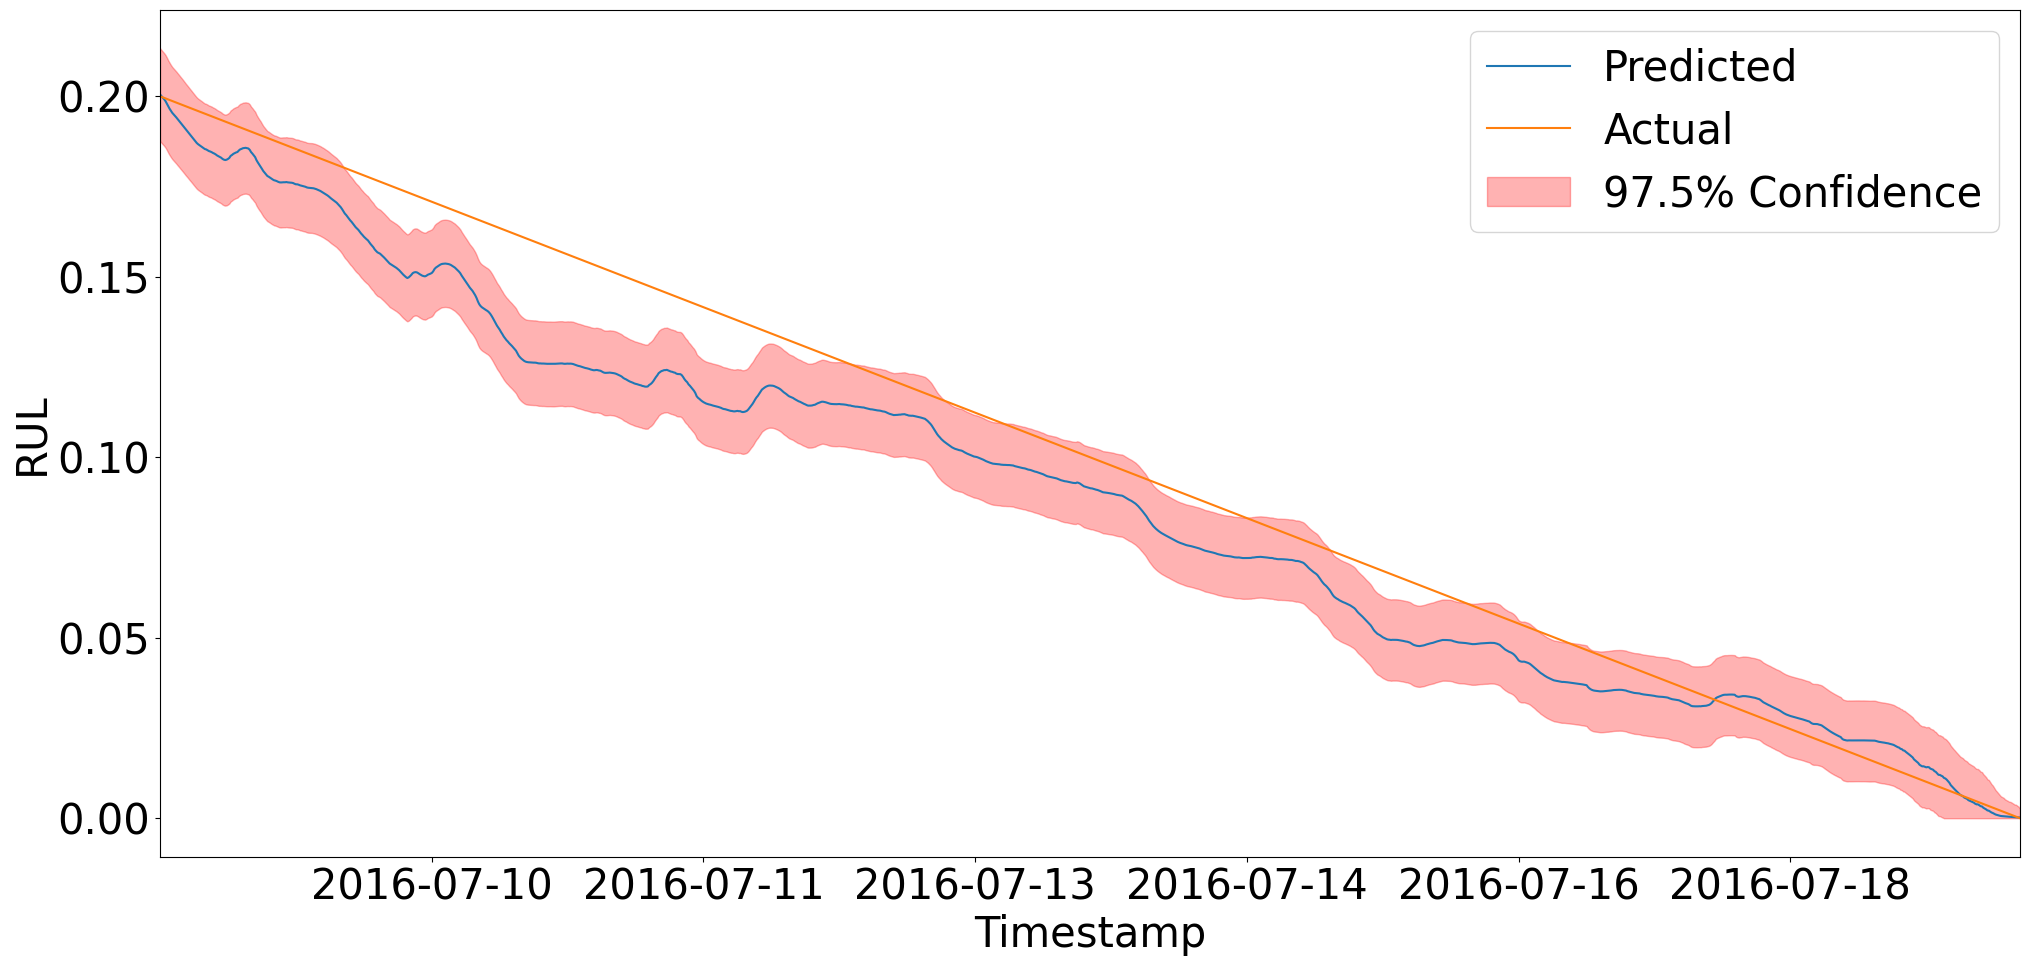

In [132]:
import matplotlib.ticker as ticker
plt.figure(figsize=(24,11))
ax = plt.gca()
x = pd.to_datetime(test.index, format="%Y-%m-%d").strftime('%Y-%m-%d')

length = test_shape
num_parts = 6 # Number of parts

xx_indices = chunk(length,num_parts)
xx = pd.to_datetime(test.index[xx_indices]).strftime('%Y-%m-%d').tolist()
plt.margins(x=0)

xxx=pd.to_datetime(test.index, format="%Y-%m-%d").strftime('%Y-%m-%d')
plt.plot(np.mean(c, axis=0), label='Predicted')
plt.plot(real3, label='Actual')
plt.fill_between(list(range(len(real3))),np.percentile(c, 2.5, axis=0), np.percentile(c, 97.5, axis=0), color='r', alpha=0.3, label='97.5% Confidence')
ax.xaxis.set_major_locator(plt.MaxNLocator(8 , prune='both'))

a= ax.get_xticks()

print(a)
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.legend()

plt.xticks(a,xx,rotation="horizontal", ha="center")


plt.savefig("/content/RUL.pdf",bbox_inches="tight")

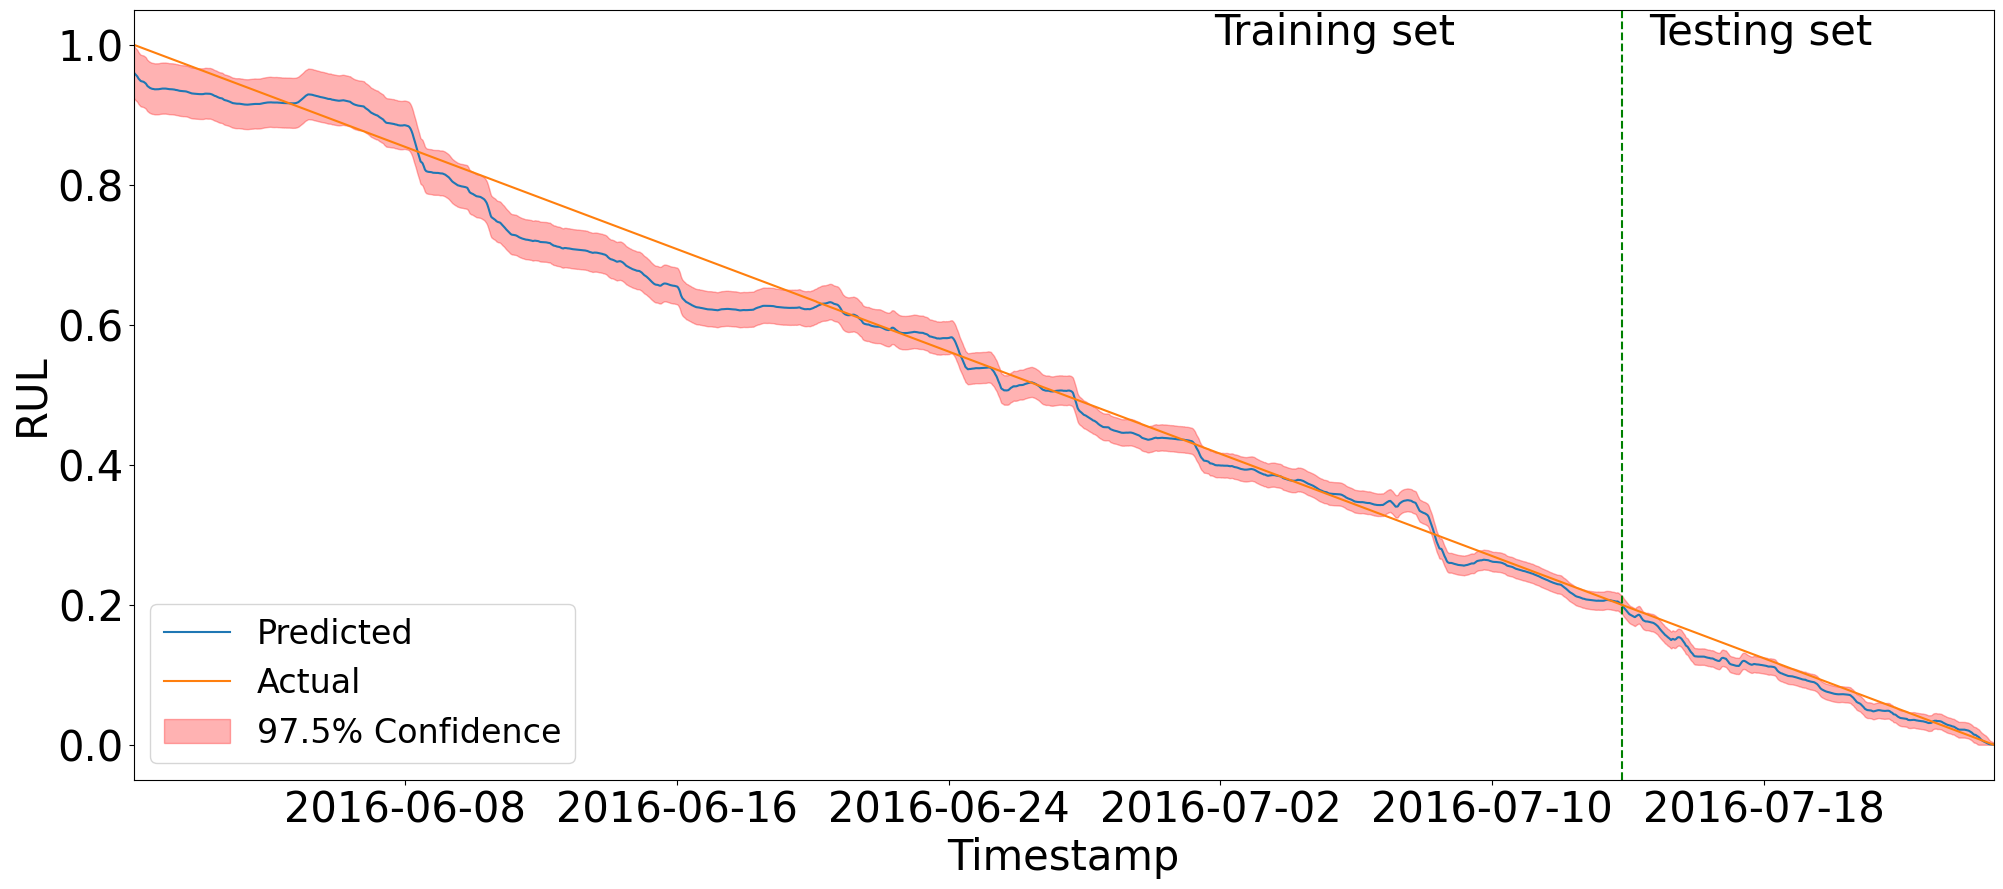

In [133]:
import matplotlib.ticker as ticker
plt.figure(figsize=(24,10))
ax = plt.gca()
x = pd.to_datetime(dfr.index, format="%Y-%m-%d").strftime('%Y-%m-%d')
length = train_shape+test_shape
num_parts = 6 # Number of parts

xx_indices = chunk(length,num_parts)
plt.margins(x=0)
xx = pd.to_datetime(dfr.index[xx_indices]).strftime('%Y-%m-%d').tolist()
xxx=pd.to_datetime(test.index, format="%Y-%m-%d").strftime('%Y-%m-%d')

plt.plot(np.mean(c3, axis=0), label='Predicted')
plt.plot(real5, label='Actual')
plt.fill_between(list(range(len(real5))),np.percentile(c3, 2.5, axis=0), np.percentile(c3, 97.5, axis=0), color='r', alpha=0.3, label='97.5% Confidence')
ax.xaxis.set_major_locator(plt.MaxNLocator(8 , prune='both'))

#plt.plot(dfb)

a= ax.get_xticks()
ax.axvline(x=train_shape, color='g', linestyle ='--')
plt.text(train_shape-1500,1, "Training set")
plt.text(train_shape+100,1, "Testing set")
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.legend(loc='lower left', fontsize=24)

plt.xticks(a,xx,rotation="horizontal", ha="center")
plt.savefig("/content/FinalRULB.pdf",bbox_inches="tight")

In [134]:
print("error on training:")
error= (mean_squared_error(np.percentile(c2, 2.5, axis=0), real4)**0.5  + sum(abs(np.percentile(c2, 2.5, axis=0)-real4)))/train_shape
print(error)
error=(mean_squared_error(np.mean(c2, axis=0), real4)**0.5  + sum(abs(np.mean(c2, axis=0)-real4)))/train_shape
print(error)
error= (mean_squared_error(np.percentile(c2, 97.5, axis=0), real4)**0.5  + sum(abs(np.percentile(c2,97.5, axis=0)-real4)))/train_shape
print(error)
print("error on testing:")
error= (mean_squared_error(np.percentile(c, 2.5, axis=0), real3)**0.5  + sum(abs(np.percentile(c, 2.5, axis=0)-real3)))/test_shape
print(error)
error=(mean_squared_error(np.mean(c, axis=0), real3)**0.5  + sum(abs(np.mean(c, axis=0)-real3)))/test_shape
print(error)
error=(mean_squared_error(np.percentile(c, 97.5, axis=0), real3)**0.5  + sum(abs(np.percentile(c,97.5, axis=0)-real3)))/test_shape
print(error)

error on training:
0.03968316202579429
0.02356431183205142
0.021971233296648643
error on testing:
0.022575331398300594
0.012374838083672762
0.006868597275415027


[ 200.  400.  600.  800. 1000. 1200.]


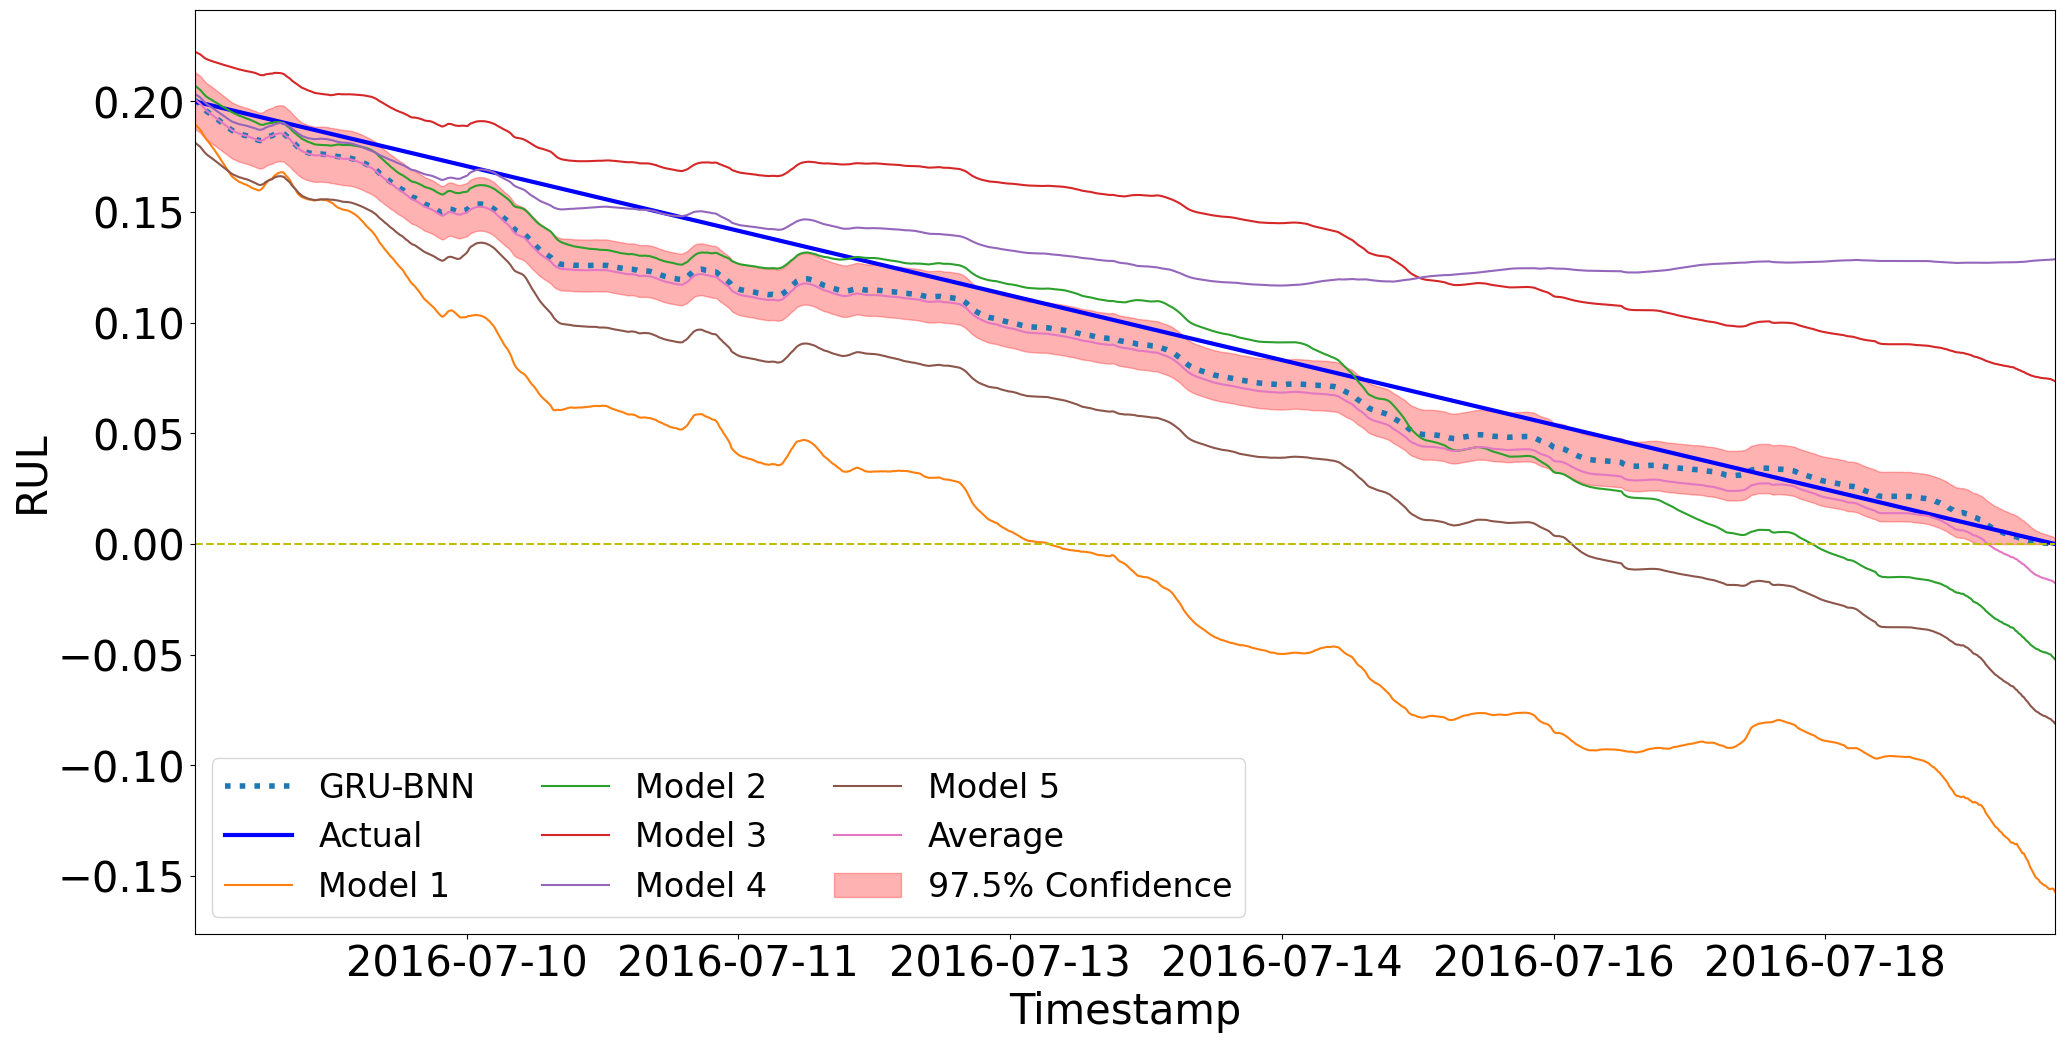

In [135]:
import matplotlib.ticker as ticker
plt.figure(figsize=(24,12))
ax = plt.gca()

x = pd.to_datetime(test.index, format="%Y-%m-%d").strftime('%Y-%m-%d')

length = test_shape
num_parts = 6 # Number of parts

xx_indices = chunk(length,num_parts)
xx = pd.to_datetime(test.index[xx_indices]).strftime('%Y-%m-%d').tolist()

plt.margins(x=0)

xxx=pd.to_datetime(test.index, format="%Y-%m-%d").strftime('%Y-%m-%d')
plt.plot(np.mean(c, axis=0), label='GRU-BNN', linewidth=4, linestyle=':')
plt.plot(real3, label='Actual',linewidth=3,color='b')
# Generate model names (e.g., 'Model 1', 'Model 2', etc.) for the first four columns
model_names = [f'Model {i + 1}' for i in range(b.shape[1] - 1)]

# Plot each column except the last one with the corresponding model name as the label
for i in range(b.shape[1] - 1):
    plt.plot(np.squeeze(b[:, i]), label=model_names[i])

# Plot the last column (average) separately and label it as "Average"
plt.plot(np.squeeze(b[:, -1]), label="Average")


plt.fill_between(list(range(len(real3))),np.percentile(c, 2.5, axis=0), np.percentile(c, 97.5, axis=0), color='r', alpha=0.3, label='97.5% Confidence')
ax.xaxis.set_major_locator(plt.MaxNLocator(8 , prune='both'))

a= ax.get_xticks()
plt.axhline(y=0, color='y', linestyle='--')
print(a)
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.legend(ncol=3,fontsize=24)

plt.xticks(a,xx,rotation="horizontal", ha="center")

plt.savefig("/content/FinalRUL2.pdf",bbox_inches="tight")

In [136]:
x=np.percentile(c, 2.5, axis=0)
x

array([0.18751356, 0.18706647, 0.18662525, ..., 0.        , 0.        ,
       0.        ])

In [137]:
#Check predicted end of life
test.index[np.where(x==0)]

DatetimeIndex(['2016-07-17 17:00:00+00:00', '2016-07-17 17:10:00+00:00',
               '2016-07-17 17:20:00+00:00', '2016-07-17 17:30:00+00:00',
               '2016-07-17 17:40:00+00:00', '2016-07-17 17:50:00+00:00',
               '2016-07-17 18:00:00+00:00', '2016-07-17 18:10:00+00:00',
               '2016-07-17 18:20:00+00:00', '2016-07-17 18:30:00+00:00',
               '2016-07-17 18:40:00+00:00', '2016-07-17 18:50:00+00:00',
               '2016-07-17 19:00:00+00:00', '2016-07-17 19:10:00+00:00',
               '2016-07-17 19:20:00+00:00', '2016-07-17 19:30:00+00:00',
               '2016-07-17 19:40:00+00:00', '2016-07-17 19:50:00+00:00',
               '2016-07-17 20:00:00+00:00', '2016-07-17 20:10:00+00:00',
               '2016-07-17 20:20:00+00:00', '2016-07-17 20:30:00+00:00',
               '2016-07-17 20:40:00+00:00', '2016-07-17 20:50:00+00:00',
               '2016-07-17 21:00:00+00:00', '2016-07-17 21:10:00+00:00',
               '2016-07-17 21:20:00+00:00', '2016-0

In [138]:
x=np.percentile(c, 50, axis=0)
test.index[np.where(x==0)]

DatetimeIndex(['2016-07-17 22:20:00+00:00', '2016-07-17 22:30:00+00:00',
               '2016-07-17 22:40:00+00:00', '2016-07-17 22:50:00+00:00',
               '2016-07-17 23:00:00+00:00', '2016-07-17 23:10:00+00:00',
               '2016-07-17 23:20:00+00:00', '2016-07-17 23:30:00+00:00',
               '2016-07-17 23:40:00+00:00', '2016-07-17 23:50:00+00:00',
               '2016-07-18 00:00:00+00:00', '2016-07-18 00:10:00+00:00',
               '2016-07-18 00:20:00+00:00', '2016-07-18 00:30:00+00:00',
               '2016-07-18 00:40:00+00:00', '2016-07-18 00:50:00+00:00',
               '2016-07-18 01:00:00+00:00', '2016-07-18 01:10:00+00:00',
               '2016-07-18 01:20:00+00:00', '2016-07-18 01:30:00+00:00',
               '2016-07-18 01:40:00+00:00', '2016-07-18 01:50:00+00:00',
               '2016-07-18 02:00:00+00:00', '2016-07-18 02:10:00+00:00',
               '2016-07-18 02:20:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Timestamp', freq=None)

In [139]:
x=np.percentile(c, 97.5, axis=0)
test.index[np.where(x==0)]

DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Timestamp', freq=None)